In [1]:
import flair
import matplotlib.pyplot as plt
import os
import pandas as pd

from codealltag_data_processor_v2025 import CodealltagDataProcessor
from flair.data import Corpus, Dictionary, Sentence
from flair.datasets import ColumnCorpus
from flair.embeddings import (
    BytePairEmbeddings,
    CharacterEmbeddings,
    StackedEmbeddings,
    TokenEmbeddings
)
from flair.models import SequenceTagger
from flair.nn import Model
from flair.trainers import ModelTrainer
from pathlib import Path

In [2]:
flair.cache_root = Path(os.path.join(*['/home', 's81481', '.flair']))

In [3]:
cdp_2022 = CodealltagDataProcessor(data_version='20220513', config_path=['codealltag_data_processor.yml'])
cdp_2020 = CodealltagDataProcessor(data_version='20200518', config_path=['codealltag_data_processor.yml'])

In [4]:
sample_size = 10_000
k = 5

In [5]:
model_dir_path = os.path.join(*["logs", "BiLSTM_CRF", "NER", str(sample_size//1000)+"K", "k"+str(k)])
os.makedirs(model_dir_path, exist_ok=True)

In [6]:
dataset = cdp_2022.get_train_dev_test_datasetdict_for_sample_size(cdp_2020, sample_size, k)

In [7]:
tmp_data_dir = Path("tmp_data_dir")
tmp_data_dir.mkdir(parents=True, exist_ok=True)
for file in tmp_data_dir.glob("*"):
    if file.is_file():
        file.unlink()

In [8]:
train_df = dataset["train"].to_pandas()
dev_df = dataset["dev"].to_pandas()
test_df = dataset["test"].to_pandas()

In [9]:
train_text = train_df.InputType1.str.cat(sep="\n")
dev_text = dev_df.InputType1.str.cat(sep="\n")
test_text = test_df.InputType1.str.cat(sep="\n")

In [10]:
with open(os.path.join(tmp_data_dir, "train.txt"), "w", encoding="utf-8") as writer:        
    writer.write(train_text)

with open(os.path.join(tmp_data_dir, "dev.txt"), "w", encoding="utf-8") as writer:        
    writer.write(dev_text)
    
with open(os.path.join(tmp_data_dir, "test.txt"), "w", encoding="utf-8") as writer:        
    writer.write(test_text)

In [11]:
!ls -la tmp_data_dir

total 4404
drwxr-xr-x 2 root root       3 Feb  4 16:38 .
drwxr-xr-x 7 root root      18 Feb  4 16:38 ..
-rw-r--r-- 1 root root  709147 Feb  4 16:38 dev.txt
-rw-r--r-- 1 root root  927496 Feb  4 16:38 test.txt
-rw-r--r-- 1 root root 2871907 Feb  4 16:38 train.txt


In [12]:
corpus: Corpus = ColumnCorpus(tmp_data_dir, {0: 'text', 1: 'ner'})

2025-02-04 16:38:45,967 Reading data from tmp_data_dir
2025-02-04 16:38:45,968 Train: tmp_data_dir/train.txt
2025-02-04 16:38:45,968 Dev: tmp_data_dir/dev.txt
2025-02-04 16:38:45,968 Test: tmp_data_dir/test.txt


In [13]:
label_dict: Dictionary = corpus.make_label_dictionary(label_type="ner")

2025-02-04 16:38:52,767 Computing label dictionary. Progress:


6400it [00:00, 26727.95it/s]

2025-02-04 16:38:53,030 Dictionary created for label 'ner' with 15 values: MALE (seen 8689 times), FAMILY (seen 5832 times), URL (seen 3273 times), EMAIL (seen 2692 times), PHONE (seen 2265 times), CITY (seen 2034 times), DATE (seen 1457 times), STREET (seen 967 times), ZIP (seen 964 times), STREETNO (seen 913 times), FEMALE (seen 887 times), UFID (seen 726 times), ORG (seen 660 times), USER (seen 146 times)


In [14]:
print(label_dict.idx2item)

[b'<unk>', b'MALE', b'FAMILY', b'URL', b'EMAIL', b'PHONE', b'CITY', b'DATE', b'STREET', b'ZIP', b'STREETNO', b'FEMALE', b'UFID', b'ORG', b'USER']


In [15]:
embeddings: TokenEmbeddings = StackedEmbeddings(
    [
        BytePairEmbeddings("de"),
        CharacterEmbeddings()
    ]
)

In [16]:
tagger: SequenceTagger = SequenceTagger(
    hidden_size=256,
    embeddings=embeddings,
    tag_dictionary=label_dict,
    tag_type="ner",
    use_crf=True,
    use_rnn=True,
    reproject_embeddings=True
)
tagger.label_dictionary.add_unk = True

2025-02-04 16:38:53,943 SequenceTagger predicts: Dictionary with 57 tags: O, S-MALE, B-MALE, E-MALE, I-MALE, S-FAMILY, B-FAMILY, E-FAMILY, I-FAMILY, S-URL, B-URL, E-URL, I-URL, S-EMAIL, B-EMAIL, E-EMAIL, I-EMAIL, S-PHONE, B-PHONE, E-PHONE, I-PHONE, S-CITY, B-CITY, E-CITY, I-CITY, S-DATE, B-DATE, E-DATE, I-DATE, S-STREET, B-STREET, E-STREET, I-STREET, S-ZIP, B-ZIP, E-ZIP, I-ZIP, S-STREETNO, B-STREETNO, E-STREETNO, I-STREETNO, S-FEMALE, B-FEMALE, E-FEMALE, I-FEMALE, S-UFID, B-UFID, E-UFID, I-UFID, S-ORG


In [17]:
trainer: ModelTrainer = ModelTrainer(tagger, corpus)

In [18]:
trainer.train(
    model_dir_path,
    learning_rate=0.1,
    mini_batch_size=16,
    max_epochs=100,
    checkpoint=True,
    write_weights=True,
    use_tensorboard=True,
    tensorboard_log_dir=model_dir_path
)

2025-02-04 16:38:53,970 tensorboard logging path is logs/BiLSTM_CRF/NER/10K/k5
2025-02-04 16:38:54,283 ----------------------------------------------------------------------------------------------------
2025-02-04 16:38:54,284 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): BytePairEmbeddings(model=0-bpe-de-100000-50)
    (list_embedding_1): CharacterEmbeddings(
      (char_embedding): Embedding(275, 25)
      (char_rnn): LSTM(25, 25, bidirectional=True)
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=150, out_features=150, bias=True)
  (rnn): LSTM(150, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=59, bias=True)
  (loss_function): ViterbiLoss()
  (crf): CRF()
)"
2025-02-04 16:38:54,285 ----------------------------------------------------------------------------------------------------
2025-02-04 16:38:54,285 Corpus: "Corpus: 64

100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]

2025-02-04 16:42:38,156 Evaluating as a multi-label problem: False
2025-02-04 16:42:38,211 DEV : loss 0.09586566686630249 - f1-score (micro avg)  0.8443


2025-02-04 16:42:38,684 BAD EPOCHS (no improvement): 0
2025-02-04 16:42:38,907 saving best model
2025-02-04 16:42:39,097 ----------------------------------------------------------------------------------------------------
2025-02-04 16:42:58,042 epoch 2 - iter 40/400 - loss 0.13302219 - samples/sec: 33.79 - lr: 0.100000
2025-02-04 16:43:17,443 epoch 2 - iter 80/400 - loss 0.12789726 - samples/sec: 33.03 - lr: 0.100000
2025-02-04 16:43:36,349 epoch 2 - iter 120/400 - loss 0.12617248 - samples/sec: 33.89 - lr: 0.100000
2025-02-04 16:43:55,764 epoch 2 - iter 160/400 - loss 0.12322652 - samples/sec: 33.01 - lr: 0.100000
2025-02-04 16:44:15,772 epoch 2 - iter 200/400 - loss 0.12048413 - samples/sec: 32.02 - lr: 0.100000
2025-02-04 16:44:34,432 epoch 2 - iter 240/400 - loss 0.11749419 - samples/sec: 34.36 - lr: 0.100000
2025-02-04 16:44:53,611 epoch 2 - iter 280/400 - loss 0.11426627 - samples/sec: 33.42 - lr: 0.100000
2025-02-04 16:45:13,259 epoch 2 - iter 320/400 - loss 0.11089390 - sample

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]

2025-02-04 16:46:19,201 Evaluating as a multi-label problem: False
2025-02-04 16:46:19,255 DEV : loss 0.05648304894566536 - f1-score (micro avg)  0.9129


2025-02-04 16:46:19,674 BAD EPOCHS (no improvement): 0
2025-02-04 16:46:19,896 saving best model
2025-02-04 16:46:20,101 ----------------------------------------------------------------------------------------------------
2025-02-04 16:46:39,933 epoch 3 - iter 40/400 - loss 0.08421212 - samples/sec: 32.28 - lr: 0.100000
2025-02-04 16:46:59,553 epoch 3 - iter 80/400 - loss 0.08693981 - samples/sec: 32.66 - lr: 0.100000
2025-02-04 16:47:18,360 epoch 3 - iter 120/400 - loss 0.08563343 - samples/sec: 34.07 - lr: 0.100000
2025-02-04 16:47:36,997 epoch 3 - iter 160/400 - loss 0.08563685 - samples/sec: 34.42 - lr: 0.100000
2025-02-04 16:47:55,292 epoch 3 - iter 200/400 - loss 0.08498733 - samples/sec: 35.02 - lr: 0.100000
2025-02-04 16:48:15,053 epoch 3 - iter 240/400 - loss 0.08357146 - samples/sec: 32.43 - lr: 0.100000
2025-02-04 16:48:33,653 epoch 3 - iter 280/400 - loss 0.08267142 - samples/sec: 34.46 - lr: 0.100000
2025-02-04 16:48:52,986 epoch 3 - iter 320/400 - loss 0.08089930 - sample

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]

2025-02-04 16:49:57,272 Evaluating as a multi-label problem: False
2025-02-04 16:49:57,327 DEV : loss 0.04492875561118126 - f1-score (micro avg)  0.9306


2025-02-04 16:49:57,756 BAD EPOCHS (no improvement): 0
2025-02-04 16:49:57,979 saving best model
2025-02-04 16:49:58,184 ----------------------------------------------------------------------------------------------------
2025-02-04 16:50:17,172 epoch 4 - iter 40/400 - loss 0.06844505 - samples/sec: 33.72 - lr: 0.100000
2025-02-04 16:50:37,860 epoch 4 - iter 80/400 - loss 0.07049321 - samples/sec: 31.00 - lr: 0.100000
2025-02-04 16:50:56,393 epoch 4 - iter 120/400 - loss 0.07037516 - samples/sec: 34.59 - lr: 0.100000
2025-02-04 16:51:15,330 epoch 4 - iter 160/400 - loss 0.07128983 - samples/sec: 33.87 - lr: 0.100000
2025-02-04 16:51:34,847 epoch 4 - iter 200/400 - loss 0.06860200 - samples/sec: 32.82 - lr: 0.100000
2025-02-04 16:51:53,478 epoch 4 - iter 240/400 - loss 0.06850485 - samples/sec: 34.46 - lr: 0.100000
2025-02-04 16:52:12,677 epoch 4 - iter 280/400 - loss 0.06734902 - samples/sec: 33.38 - lr: 0.100000
2025-02-04 16:52:31,672 epoch 4 - iter 320/400 - loss 0.06705522 - sample

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.92it/s]

2025-02-04 16:53:37,002 Evaluating as a multi-label problem: False
2025-02-04 16:53:37,056 DEV : loss 0.03792620077729225 - f1-score (micro avg)  0.9393


2025-02-04 16:53:37,523 BAD EPOCHS (no improvement): 0
2025-02-04 16:53:37,745 saving best model
2025-02-04 16:53:37,952 ----------------------------------------------------------------------------------------------------
2025-02-04 16:53:56,861 epoch 5 - iter 40/400 - loss 0.06964933 - samples/sec: 33.86 - lr: 0.100000
2025-02-04 16:54:15,419 epoch 5 - iter 80/400 - loss 0.06211883 - samples/sec: 34.54 - lr: 0.100000
2025-02-04 16:54:35,117 epoch 5 - iter 120/400 - loss 0.06267392 - samples/sec: 32.53 - lr: 0.100000
2025-02-04 16:54:55,618 epoch 5 - iter 160/400 - loss 0.06189446 - samples/sec: 31.25 - lr: 0.100000
2025-02-04 16:55:14,111 epoch 5 - iter 200/400 - loss 0.06182223 - samples/sec: 34.64 - lr: 0.100000
2025-02-04 16:55:32,852 epoch 5 - iter 240/400 - loss 0.06162086 - samples/sec: 34.18 - lr: 0.100000
2025-02-04 16:55:51,438 epoch 5 - iter 280/400 - loss 0.06075389 - samples/sec: 34.47 - lr: 0.100000
2025-02-04 16:56:10,868 epoch 5 - iter 320/400 - loss 0.06068449 - sample

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]

2025-02-04 16:57:15,955 Evaluating as a multi-label problem: False
2025-02-04 16:57:16,010 DEV : loss 0.035507526248693466 - f1-score (micro avg)  0.9403


2025-02-04 16:57:16,431 BAD EPOCHS (no improvement): 0
2025-02-04 16:57:16,653 saving best model
2025-02-04 16:57:16,860 ----------------------------------------------------------------------------------------------------
2025-02-04 16:57:36,200 epoch 6 - iter 40/400 - loss 0.05617621 - samples/sec: 33.10 - lr: 0.100000
2025-02-04 16:57:55,777 epoch 6 - iter 80/400 - loss 0.05523558 - samples/sec: 32.75 - lr: 0.100000
2025-02-04 16:58:15,647 epoch 6 - iter 120/400 - loss 0.05611422 - samples/sec: 32.25 - lr: 0.100000
2025-02-04 16:58:34,991 epoch 6 - iter 160/400 - loss 0.05432357 - samples/sec: 33.13 - lr: 0.100000
2025-02-04 16:58:53,958 epoch 6 - iter 200/400 - loss 0.05469733 - samples/sec: 33.78 - lr: 0.100000
2025-02-04 16:59:12,575 epoch 6 - iter 240/400 - loss 0.05468755 - samples/sec: 34.42 - lr: 0.100000
2025-02-04 16:59:32,718 epoch 6 - iter 280/400 - loss 0.05454868 - samples/sec: 31.80 - lr: 0.100000
2025-02-04 16:59:52,050 epoch 6 - iter 320/400 - loss 0.05421334 - sample

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]

2025-02-04 17:00:55,673 Evaluating as a multi-label problem: False
2025-02-04 17:00:55,729 DEV : loss 0.033323973417282104 - f1-score (micro avg)  0.9478


2025-02-04 17:00:56,170 BAD EPOCHS (no improvement): 0
2025-02-04 17:00:56,394 saving best model
2025-02-04 17:00:56,651 ----------------------------------------------------------------------------------------------------
2025-02-04 17:01:15,595 epoch 7 - iter 40/400 - loss 0.05034088 - samples/sec: 33.80 - lr: 0.100000
2025-02-04 17:01:34,937 epoch 7 - iter 80/400 - loss 0.04881641 - samples/sec: 33.22 - lr: 0.100000
2025-02-04 17:01:53,425 epoch 7 - iter 120/400 - loss 0.04958080 - samples/sec: 34.66 - lr: 0.100000
2025-02-04 17:02:12,757 epoch 7 - iter 160/400 - loss 0.04901924 - samples/sec: 33.20 - lr: 0.100000
2025-02-04 17:02:31,597 epoch 7 - iter 200/400 - loss 0.04817208 - samples/sec: 34.03 - lr: 0.100000
2025-02-04 17:02:51,293 epoch 7 - iter 240/400 - loss 0.04844811 - samples/sec: 32.54 - lr: 0.100000
2025-02-04 17:03:10,092 epoch 7 - iter 280/400 - loss 0.05030058 - samples/sec: 34.11 - lr: 0.100000
2025-02-04 17:03:28,944 epoch 7 - iter 320/400 - loss 0.05044929 - sample

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.92it/s]

2025-02-04 17:04:34,709 Evaluating as a multi-label problem: False
2025-02-04 17:04:34,762 DEV : loss 0.02927461825311184 - f1-score (micro avg)  0.9498


2025-02-04 17:04:35,225 BAD EPOCHS (no improvement): 0
2025-02-04 17:04:35,445 saving best model
2025-02-04 17:04:35,656 ----------------------------------------------------------------------------------------------------
2025-02-04 17:04:54,444 epoch 8 - iter 40/400 - loss 0.04774306 - samples/sec: 34.08 - lr: 0.100000
2025-02-04 17:05:12,853 epoch 8 - iter 80/400 - loss 0.04758253 - samples/sec: 34.81 - lr: 0.100000
2025-02-04 17:05:31,393 epoch 8 - iter 120/400 - loss 0.04869759 - samples/sec: 34.57 - lr: 0.100000
2025-02-04 17:05:50,316 epoch 8 - iter 160/400 - loss 0.04948587 - samples/sec: 33.88 - lr: 0.100000
2025-02-04 17:06:09,532 epoch 8 - iter 200/400 - loss 0.04879672 - samples/sec: 33.38 - lr: 0.100000
2025-02-04 17:06:29,104 epoch 8 - iter 240/400 - loss 0.04807894 - samples/sec: 32.75 - lr: 0.100000
2025-02-04 17:06:48,482 epoch 8 - iter 280/400 - loss 0.04802768 - samples/sec: 33.09 - lr: 0.100000
2025-02-04 17:07:08,077 epoch 8 - iter 320/400 - loss 0.04737875 - sample

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]

2025-02-04 17:08:13,426 Evaluating as a multi-label problem: False
2025-02-04 17:08:13,480 DEV : loss 0.027305997908115387 - f1-score (micro avg)  0.9549


2025-02-04 17:08:13,912 BAD EPOCHS (no improvement): 0
2025-02-04 17:08:14,145 saving best model
2025-02-04 17:08:14,355 ----------------------------------------------------------------------------------------------------
2025-02-04 17:08:32,423 epoch 9 - iter 40/400 - loss 0.04976298 - samples/sec: 35.43 - lr: 0.100000
2025-02-04 17:08:51,525 epoch 9 - iter 80/400 - loss 0.04655541 - samples/sec: 33.62 - lr: 0.100000
2025-02-04 17:09:10,749 epoch 9 - iter 120/400 - loss 0.04675405 - samples/sec: 33.36 - lr: 0.100000
2025-02-04 17:09:30,437 epoch 9 - iter 160/400 - loss 0.04649884 - samples/sec: 32.57 - lr: 0.100000
2025-02-04 17:09:49,765 epoch 9 - iter 200/400 - loss 0.04548735 - samples/sec: 33.16 - lr: 0.100000
2025-02-04 17:10:08,798 epoch 9 - iter 240/400 - loss 0.04534492 - samples/sec: 33.68 - lr: 0.100000
2025-02-04 17:10:28,230 epoch 9 - iter 280/400 - loss 0.04597513 - samples/sec: 33.02 - lr: 0.100000
2025-02-04 17:10:47,865 epoch 9 - iter 320/400 - loss 0.04557658 - sample

100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]

2025-02-04 17:11:54,570 Evaluating as a multi-label problem: False
2025-02-04 17:11:54,627 DEV : loss 0.02693457528948784 - f1-score (micro avg)  0.9553


2025-02-04 17:11:55,172 BAD EPOCHS (no improvement): 0
2025-02-04 17:11:55,396 saving best model
2025-02-04 17:11:55,606 ----------------------------------------------------------------------------------------------------
2025-02-04 17:12:14,930 epoch 10 - iter 40/400 - loss 0.04187051 - samples/sec: 33.13 - lr: 0.100000
2025-02-04 17:12:34,590 epoch 10 - iter 80/400 - loss 0.04367077 - samples/sec: 32.59 - lr: 0.100000
2025-02-04 17:12:54,036 epoch 10 - iter 120/400 - loss 0.04330861 - samples/sec: 32.95 - lr: 0.100000
2025-02-04 17:13:13,093 epoch 10 - iter 160/400 - loss 0.04336419 - samples/sec: 33.63 - lr: 0.100000
2025-02-04 17:13:32,622 epoch 10 - iter 200/400 - loss 0.04350743 - samples/sec: 32.81 - lr: 0.100000
2025-02-04 17:13:52,303 epoch 10 - iter 240/400 - loss 0.04443383 - samples/sec: 32.58 - lr: 0.100000
2025-02-04 17:14:11,190 epoch 10 - iter 280/400 - loss 0.04384145 - samples/sec: 33.92 - lr: 0.100000
2025-02-04 17:14:29,580 epoch 10 - iter 320/400 - loss 0.04383338 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]

2025-02-04 17:15:34,326 Evaluating as a multi-label problem: False
2025-02-04 17:15:34,379 DEV : loss 0.025254493579268456 - f1-score (micro avg)  0.956


2025-02-04 17:15:34,802 BAD EPOCHS (no improvement): 0
2025-02-04 17:15:35,033 saving best model
2025-02-04 17:15:35,240 ----------------------------------------------------------------------------------------------------
2025-02-04 17:15:54,342 epoch 11 - iter 40/400 - loss 0.03745311 - samples/sec: 33.52 - lr: 0.100000
2025-02-04 17:16:13,406 epoch 11 - iter 80/400 - loss 0.04344268 - samples/sec: 33.65 - lr: 0.100000
2025-02-04 17:16:32,749 epoch 11 - iter 120/400 - loss 0.04322460 - samples/sec: 33.12 - lr: 0.100000
2025-02-04 17:16:52,543 epoch 11 - iter 160/400 - loss 0.04176600 - samples/sec: 32.37 - lr: 0.100000
2025-02-04 17:17:12,056 epoch 11 - iter 200/400 - loss 0.04214742 - samples/sec: 32.83 - lr: 0.100000
2025-02-04 17:17:31,118 epoch 11 - iter 240/400 - loss 0.04250267 - samples/sec: 33.62 - lr: 0.100000
2025-02-04 17:17:50,549 epoch 11 - iter 280/400 - loss 0.04394948 - samples/sec: 32.97 - lr: 0.100000
2025-02-04 17:18:09,600 epoch 11 - iter 320/400 - loss 0.04329610 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]

2025-02-04 17:19:15,260 Evaluating as a multi-label problem: False
2025-02-04 17:19:15,313 DEV : loss 0.026088442653417587 - f1-score (micro avg)  0.9578


2025-02-04 17:19:15,790 BAD EPOCHS (no improvement): 0
2025-02-04 17:19:16,014 saving best model
2025-02-04 17:19:16,226 ----------------------------------------------------------------------------------------------------
2025-02-04 17:19:35,453 epoch 12 - iter 40/400 - loss 0.04247852 - samples/sec: 33.30 - lr: 0.100000
2025-02-04 17:19:54,815 epoch 12 - iter 80/400 - loss 0.04084038 - samples/sec: 33.10 - lr: 0.100000
2025-02-04 17:20:14,621 epoch 12 - iter 120/400 - loss 0.04302314 - samples/sec: 32.35 - lr: 0.100000
2025-02-04 17:20:33,589 epoch 12 - iter 160/400 - loss 0.04222267 - samples/sec: 33.78 - lr: 0.100000
2025-02-04 17:20:52,890 epoch 12 - iter 200/400 - loss 0.04189849 - samples/sec: 33.20 - lr: 0.100000
2025-02-04 17:21:12,530 epoch 12 - iter 240/400 - loss 0.04142551 - samples/sec: 32.63 - lr: 0.100000
2025-02-04 17:21:31,740 epoch 12 - iter 280/400 - loss 0.04096585 - samples/sec: 33.35 - lr: 0.100000
2025-02-04 17:21:50,320 epoch 12 - iter 320/400 - loss 0.04050609 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]

2025-02-04 17:22:55,876 Evaluating as a multi-label problem: False
2025-02-04 17:22:55,930 DEV : loss 0.024718884378671646 - f1-score (micro avg)  0.9593


2025-02-04 17:22:56,388 BAD EPOCHS (no improvement): 0
2025-02-04 17:22:56,617 saving best model
2025-02-04 17:22:56,830 ----------------------------------------------------------------------------------------------------
2025-02-04 17:23:16,567 epoch 13 - iter 40/400 - loss 0.03647609 - samples/sec: 32.44 - lr: 0.100000
2025-02-04 17:23:35,658 epoch 13 - iter 80/400 - loss 0.03698784 - samples/sec: 33.59 - lr: 0.100000
2025-02-04 17:23:54,856 epoch 13 - iter 120/400 - loss 0.03677502 - samples/sec: 33.37 - lr: 0.100000
2025-02-04 17:24:14,422 epoch 13 - iter 160/400 - loss 0.03681790 - samples/sec: 32.75 - lr: 0.100000
2025-02-04 17:24:33,041 epoch 13 - iter 200/400 - loss 0.03821195 - samples/sec: 34.41 - lr: 0.100000
2025-02-04 17:24:52,566 epoch 13 - iter 240/400 - loss 0.03808551 - samples/sec: 32.82 - lr: 0.100000
2025-02-04 17:25:12,776 epoch 13 - iter 280/400 - loss 0.03749034 - samples/sec: 31.70 - lr: 0.100000
2025-02-04 17:25:32,088 epoch 13 - iter 320/400 - loss 0.03809272 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]

2025-02-04 17:26:37,544 Evaluating as a multi-label problem: False
2025-02-04 17:26:37,598 DEV : loss 0.022686270996928215 - f1-score (micro avg)  0.9597


2025-02-04 17:26:38,047 BAD EPOCHS (no improvement): 0
2025-02-04 17:26:38,278 saving best model
2025-02-04 17:26:38,490 ----------------------------------------------------------------------------------------------------
2025-02-04 17:26:56,522 epoch 14 - iter 40/400 - loss 0.03553029 - samples/sec: 35.50 - lr: 0.100000
2025-02-04 17:27:15,135 epoch 14 - iter 80/400 - loss 0.03750300 - samples/sec: 34.43 - lr: 0.100000
2025-02-04 17:27:34,585 epoch 14 - iter 120/400 - loss 0.03736386 - samples/sec: 32.94 - lr: 0.100000
2025-02-04 17:27:54,222 epoch 14 - iter 160/400 - loss 0.03857027 - samples/sec: 32.65 - lr: 0.100000
2025-02-04 17:28:13,836 epoch 14 - iter 200/400 - loss 0.03901896 - samples/sec: 32.67 - lr: 0.100000
2025-02-04 17:28:33,941 epoch 14 - iter 240/400 - loss 0.03868699 - samples/sec: 31.88 - lr: 0.100000
2025-02-04 17:28:53,670 epoch 14 - iter 280/400 - loss 0.03877263 - samples/sec: 32.47 - lr: 0.100000
2025-02-04 17:29:12,921 epoch 14 - iter 320/400 - loss 0.03899947 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]

2025-02-04 17:30:18,202 Evaluating as a multi-label problem: False
2025-02-04 17:30:18,256 DEV : loss 0.023438148200511932 - f1-score (micro avg)  0.9603


2025-02-04 17:30:18,833 BAD EPOCHS (no improvement): 0
2025-02-04 17:30:19,064 saving best model
2025-02-04 17:30:19,279 ----------------------------------------------------------------------------------------------------
2025-02-04 17:30:38,373 epoch 15 - iter 40/400 - loss 0.03430095 - samples/sec: 33.53 - lr: 0.100000
2025-02-04 17:30:57,610 epoch 15 - iter 80/400 - loss 0.03491344 - samples/sec: 33.32 - lr: 0.100000
2025-02-04 17:31:16,987 epoch 15 - iter 120/400 - loss 0.03682132 - samples/sec: 33.07 - lr: 0.100000
2025-02-04 17:31:36,040 epoch 15 - iter 160/400 - loss 0.03703610 - samples/sec: 33.63 - lr: 0.100000
2025-02-04 17:31:55,608 epoch 15 - iter 200/400 - loss 0.03782681 - samples/sec: 32.74 - lr: 0.100000
2025-02-04 17:32:14,888 epoch 15 - iter 240/400 - loss 0.03754108 - samples/sec: 33.24 - lr: 0.100000
2025-02-04 17:32:33,917 epoch 15 - iter 280/400 - loss 0.03753569 - samples/sec: 33.67 - lr: 0.100000
2025-02-04 17:32:53,603 epoch 15 - iter 320/400 - loss 0.03788593 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]

2025-02-04 17:33:59,663 Evaluating as a multi-label problem: False
2025-02-04 17:33:59,716 DEV : loss 0.022732382640242577 - f1-score (micro avg)  0.9619


2025-02-04 17:34:00,177 BAD EPOCHS (no improvement): 0
2025-02-04 17:34:00,404 saving best model
2025-02-04 17:34:00,619 ----------------------------------------------------------------------------------------------------
2025-02-04 17:34:20,202 epoch 16 - iter 40/400 - loss 0.03800895 - samples/sec: 32.69 - lr: 0.100000
2025-02-04 17:34:39,630 epoch 16 - iter 80/400 - loss 0.03724052 - samples/sec: 32.98 - lr: 0.100000
2025-02-04 17:34:59,792 epoch 16 - iter 120/400 - loss 0.03673007 - samples/sec: 31.78 - lr: 0.100000
2025-02-04 17:35:18,986 epoch 16 - iter 160/400 - loss 0.03673666 - samples/sec: 33.38 - lr: 0.100000
2025-02-04 17:35:37,624 epoch 16 - iter 200/400 - loss 0.03635011 - samples/sec: 34.38 - lr: 0.100000
2025-02-04 17:35:56,779 epoch 16 - iter 240/400 - loss 0.03695289 - samples/sec: 33.46 - lr: 0.100000
2025-02-04 17:36:15,397 epoch 16 - iter 280/400 - loss 0.03626105 - samples/sec: 34.42 - lr: 0.100000
2025-02-04 17:36:35,285 epoch 16 - iter 320/400 - loss 0.03586290 

100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.67it/s]

2025-02-04 17:37:41,067 Evaluating as a multi-label problem: False
2025-02-04 17:37:41,122 DEV : loss 0.021806009113788605 - f1-score (micro avg)  0.9592


2025-02-04 17:37:41,757 BAD EPOCHS (no improvement): 1
2025-02-04 17:37:42,100 ----------------------------------------------------------------------------------------------------
2025-02-04 17:38:01,697 epoch 17 - iter 40/400 - loss 0.03688926 - samples/sec: 32.67 - lr: 0.100000
2025-02-04 17:38:20,836 epoch 17 - iter 80/400 - loss 0.03673261 - samples/sec: 33.49 - lr: 0.100000
2025-02-04 17:38:40,341 epoch 17 - iter 120/400 - loss 0.03528793 - samples/sec: 32.85 - lr: 0.100000
2025-02-04 17:38:59,971 epoch 17 - iter 160/400 - loss 0.03576086 - samples/sec: 32.65 - lr: 0.100000
2025-02-04 17:39:19,100 epoch 17 - iter 200/400 - loss 0.03541706 - samples/sec: 33.49 - lr: 0.100000
2025-02-04 17:39:38,805 epoch 17 - iter 240/400 - loss 0.03533748 - samples/sec: 32.52 - lr: 0.100000
2025-02-04 17:39:59,101 epoch 17 - iter 280/400 - loss 0.03502423 - samples/sec: 31.57 - lr: 0.100000
2025-02-04 17:40:19,072 epoch 17 - iter 320/400 - loss 0.03467627 - samples/sec: 32.09 - lr: 0.100000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]

2025-02-04 17:41:24,543 Evaluating as a multi-label problem: False
2025-02-04 17:41:24,598 DEV : loss 0.021529754623770714 - f1-score (micro avg)  0.962


2025-02-04 17:41:25,050 BAD EPOCHS (no improvement): 0
2025-02-04 17:41:25,271 saving best model
2025-02-04 17:41:25,481 ----------------------------------------------------------------------------------------------------
2025-02-04 17:41:45,335 epoch 18 - iter 40/400 - loss 0.03482136 - samples/sec: 32.25 - lr: 0.100000
2025-02-04 17:42:04,751 epoch 18 - iter 80/400 - loss 0.03540670 - samples/sec: 33.21 - lr: 0.100000
2025-02-04 17:42:23,786 epoch 18 - iter 120/400 - loss 0.03567753 - samples/sec: 33.66 - lr: 0.100000
2025-02-04 17:42:43,285 epoch 18 - iter 160/400 - loss 0.03518360 - samples/sec: 32.86 - lr: 0.100000
2025-02-04 17:43:02,651 epoch 18 - iter 200/400 - loss 0.03436865 - samples/sec: 33.08 - lr: 0.100000
2025-02-04 17:43:21,731 epoch 18 - iter 240/400 - loss 0.03404681 - samples/sec: 33.60 - lr: 0.100000
2025-02-04 17:43:40,617 epoch 18 - iter 280/400 - loss 0.03477473 - samples/sec: 33.92 - lr: 0.100000
2025-02-04 17:43:59,638 epoch 18 - iter 320/400 - loss 0.03460647 

100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]

2025-02-04 17:45:05,454 Evaluating as a multi-label problem: False
2025-02-04 17:45:05,508 DEV : loss 0.022084740921854973 - f1-score (micro avg)  0.9608


2025-02-04 17:45:06,086 BAD EPOCHS (no improvement): 1
2025-02-04 17:45:06,318 ----------------------------------------------------------------------------------------------------
2025-02-04 17:45:25,178 epoch 19 - iter 40/400 - loss 0.03378564 - samples/sec: 33.95 - lr: 0.100000
2025-02-04 17:45:43,850 epoch 19 - iter 80/400 - loss 0.03319428 - samples/sec: 34.34 - lr: 0.100000
2025-02-04 17:46:03,183 epoch 19 - iter 120/400 - loss 0.03355667 - samples/sec: 33.14 - lr: 0.100000
2025-02-04 17:46:22,584 epoch 19 - iter 160/400 - loss 0.03415565 - samples/sec: 33.05 - lr: 0.100000
2025-02-04 17:46:41,807 epoch 19 - iter 200/400 - loss 0.03348856 - samples/sec: 33.33 - lr: 0.100000
2025-02-04 17:47:01,400 epoch 19 - iter 240/400 - loss 0.03292803 - samples/sec: 32.72 - lr: 0.100000
2025-02-04 17:47:19,896 epoch 19 - iter 280/400 - loss 0.03305491 - samples/sec: 34.64 - lr: 0.100000
2025-02-04 17:47:39,325 epoch 19 - iter 320/400 - loss 0.03346455 - samples/sec: 33.01 - lr: 0.100000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.92it/s]

2025-02-04 17:48:44,807 Evaluating as a multi-label problem: False
2025-02-04 17:48:44,862 DEV : loss 0.023018257692456245 - f1-score (micro avg)  0.9612


2025-02-04 17:48:45,355 BAD EPOCHS (no improvement): 2
2025-02-04 17:48:45,591 ----------------------------------------------------------------------------------------------------
2025-02-04 17:49:05,564 epoch 20 - iter 40/400 - loss 0.02684626 - samples/sec: 32.05 - lr: 0.100000
2025-02-04 17:49:26,142 epoch 20 - iter 80/400 - loss 0.03052800 - samples/sec: 31.15 - lr: 0.100000
2025-02-04 17:49:45,421 epoch 20 - iter 120/400 - loss 0.03213705 - samples/sec: 33.23 - lr: 0.100000
2025-02-04 17:50:04,494 epoch 20 - iter 160/400 - loss 0.03129538 - samples/sec: 33.61 - lr: 0.100000
2025-02-04 17:50:24,751 epoch 20 - iter 200/400 - loss 0.03157379 - samples/sec: 31.63 - lr: 0.100000
2025-02-04 17:50:43,642 epoch 20 - iter 240/400 - loss 0.03189910 - samples/sec: 33.92 - lr: 0.100000
2025-02-04 17:51:02,556 epoch 20 - iter 280/400 - loss 0.03230323 - samples/sec: 33.88 - lr: 0.100000
2025-02-04 17:51:21,923 epoch 20 - iter 320/400 - loss 0.03221437 - samples/sec: 33.14 - lr: 0.100000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]

2025-02-04 17:52:26,857 Evaluating as a multi-label problem: False
2025-02-04 17:52:26,912 DEV : loss 0.020468130707740784 - f1-score (micro avg)  0.9609


2025-02-04 17:52:27,493 BAD EPOCHS (no improvement): 3
2025-02-04 17:52:27,723 ----------------------------------------------------------------------------------------------------
2025-02-04 17:52:48,428 epoch 21 - iter 40/400 - loss 0.02928484 - samples/sec: 30.92 - lr: 0.100000
2025-02-04 17:53:06,787 epoch 21 - iter 80/400 - loss 0.02996465 - samples/sec: 34.92 - lr: 0.100000
2025-02-04 17:53:25,960 epoch 21 - iter 120/400 - loss 0.02981762 - samples/sec: 33.42 - lr: 0.100000
2025-02-04 17:53:44,707 epoch 21 - iter 160/400 - loss 0.03128454 - samples/sec: 34.24 - lr: 0.100000
2025-02-04 17:54:05,324 epoch 21 - iter 200/400 - loss 0.03160152 - samples/sec: 31.08 - lr: 0.100000
2025-02-04 17:54:24,859 epoch 21 - iter 240/400 - loss 0.03114978 - samples/sec: 32.85 - lr: 0.100000
2025-02-04 17:54:44,140 epoch 21 - iter 280/400 - loss 0.03154218 - samples/sec: 33.23 - lr: 0.100000
2025-02-04 17:55:03,254 epoch 21 - iter 320/400 - loss 0.03210850 - samples/sec: 33.56 - lr: 0.100000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.93it/s]

2025-02-04 17:56:08,541 Evaluating as a multi-label problem: False
2025-02-04 17:56:08,595 DEV : loss 0.01966206356883049 - f1-score (micro avg)  0.9635


2025-02-04 17:56:09,074 BAD EPOCHS (no improvement): 0
2025-02-04 17:56:09,302 saving best model
2025-02-04 17:56:09,520 ----------------------------------------------------------------------------------------------------
2025-02-04 17:56:28,861 epoch 22 - iter 40/400 - loss 0.02906538 - samples/sec: 33.10 - lr: 0.100000
2025-02-04 17:56:48,225 epoch 22 - iter 80/400 - loss 0.03072038 - samples/sec: 33.15 - lr: 0.100000
2025-02-04 17:57:07,713 epoch 22 - iter 120/400 - loss 0.03053030 - samples/sec: 32.88 - lr: 0.100000
2025-02-04 17:57:27,541 epoch 22 - iter 160/400 - loss 0.03116990 - samples/sec: 32.38 - lr: 0.100000
2025-02-04 17:57:46,926 epoch 22 - iter 200/400 - loss 0.03129969 - samples/sec: 33.05 - lr: 0.100000
2025-02-04 17:58:05,714 epoch 22 - iter 240/400 - loss 0.03167153 - samples/sec: 34.14 - lr: 0.100000
2025-02-04 17:58:25,056 epoch 22 - iter 280/400 - loss 0.03176090 - samples/sec: 33.12 - lr: 0.100000
2025-02-04 17:58:46,529 epoch 22 - iter 320/400 - loss 0.03184662 

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]

2025-02-04 17:59:50,367 Evaluating as a multi-label problem: False
2025-02-04 17:59:50,422 DEV : loss 0.019409334287047386 - f1-score (micro avg)  0.9654


2025-02-04 17:59:50,851 BAD EPOCHS (no improvement): 0
2025-02-04 17:59:51,076 saving best model
2025-02-04 17:59:51,290 ----------------------------------------------------------------------------------------------------
2025-02-04 18:00:09,717 epoch 23 - iter 40/400 - loss 0.03056407 - samples/sec: 34.74 - lr: 0.100000
2025-02-04 18:00:29,545 epoch 23 - iter 80/400 - loss 0.03023305 - samples/sec: 32.33 - lr: 0.100000
2025-02-04 18:00:48,462 epoch 23 - iter 120/400 - loss 0.03076080 - samples/sec: 33.87 - lr: 0.100000
2025-02-04 18:01:07,828 epoch 23 - iter 160/400 - loss 0.03034466 - samples/sec: 33.20 - lr: 0.100000
2025-02-04 18:01:27,000 epoch 23 - iter 200/400 - loss 0.03171547 - samples/sec: 33.42 - lr: 0.100000
2025-02-04 18:01:46,116 epoch 23 - iter 240/400 - loss 0.03118967 - samples/sec: 33.52 - lr: 0.100000
2025-02-04 18:02:05,693 epoch 23 - iter 280/400 - loss 0.03085893 - samples/sec: 32.73 - lr: 0.100000
2025-02-04 18:02:25,292 epoch 23 - iter 320/400 - loss 0.03100703 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]

2025-02-04 18:03:28,884 Evaluating as a multi-label problem: False
2025-02-04 18:03:28,937 DEV : loss 0.019228262826800346 - f1-score (micro avg)  0.9655


2025-02-04 18:03:29,408 BAD EPOCHS (no improvement): 0
2025-02-04 18:03:29,640 saving best model
2025-02-04 18:03:29,856 ----------------------------------------------------------------------------------------------------
2025-02-04 18:03:48,949 epoch 24 - iter 40/400 - loss 0.03044465 - samples/sec: 33.53 - lr: 0.100000
2025-02-04 18:04:07,653 epoch 24 - iter 80/400 - loss 0.03072051 - samples/sec: 34.26 - lr: 0.100000
2025-02-04 18:04:27,015 epoch 24 - iter 120/400 - loss 0.03016879 - samples/sec: 33.09 - lr: 0.100000
2025-02-04 18:04:46,111 epoch 24 - iter 160/400 - loss 0.02934261 - samples/sec: 33.56 - lr: 0.100000
2025-02-04 18:05:04,996 epoch 24 - iter 200/400 - loss 0.02907831 - samples/sec: 33.93 - lr: 0.100000
2025-02-04 18:05:24,564 epoch 24 - iter 240/400 - loss 0.02949576 - samples/sec: 32.75 - lr: 0.100000
2025-02-04 18:05:44,255 epoch 24 - iter 280/400 - loss 0.02990538 - samples/sec: 32.54 - lr: 0.100000
2025-02-04 18:06:03,684 epoch 24 - iter 320/400 - loss 0.03033992 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]

2025-02-04 18:07:08,674 Evaluating as a multi-label problem: False
2025-02-04 18:07:08,727 DEV : loss 0.019567037001252174 - f1-score (micro avg)  0.9649


2025-02-04 18:07:09,149 BAD EPOCHS (no improvement): 1
2025-02-04 18:07:09,372 ----------------------------------------------------------------------------------------------------
2025-02-04 18:07:29,683 epoch 25 - iter 40/400 - loss 0.02830837 - samples/sec: 31.52 - lr: 0.100000
2025-02-04 18:07:48,934 epoch 25 - iter 80/400 - loss 0.02900817 - samples/sec: 33.30 - lr: 0.100000
2025-02-04 18:08:07,746 epoch 25 - iter 120/400 - loss 0.03124556 - samples/sec: 34.06 - lr: 0.100000
2025-02-04 18:08:27,407 epoch 25 - iter 160/400 - loss 0.03056720 - samples/sec: 32.59 - lr: 0.100000
2025-02-04 18:08:47,041 epoch 25 - iter 200/400 - loss 0.03058990 - samples/sec: 32.63 - lr: 0.100000
2025-02-04 18:09:06,131 epoch 25 - iter 240/400 - loss 0.03009240 - samples/sec: 33.57 - lr: 0.100000
2025-02-04 18:09:25,732 epoch 25 - iter 280/400 - loss 0.02971044 - samples/sec: 32.69 - lr: 0.100000
2025-02-04 18:09:45,014 epoch 25 - iter 320/400 - loss 0.03042644 - samples/sec: 33.28 - lr: 0.100000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]

2025-02-04 18:10:50,708 Evaluating as a multi-label problem: False
2025-02-04 18:10:50,763 DEV : loss 0.019447388127446175 - f1-score (micro avg)  0.9649


2025-02-04 18:10:51,276 BAD EPOCHS (no improvement): 2
2025-02-04 18:10:51,510 ----------------------------------------------------------------------------------------------------
2025-02-04 18:11:11,618 epoch 26 - iter 40/400 - loss 0.02672865 - samples/sec: 31.84 - lr: 0.100000
2025-02-04 18:11:30,568 epoch 26 - iter 80/400 - loss 0.02810484 - samples/sec: 33.85 - lr: 0.100000
2025-02-04 18:11:50,581 epoch 26 - iter 120/400 - loss 0.02785670 - samples/sec: 32.01 - lr: 0.100000
2025-02-04 18:12:10,104 epoch 26 - iter 160/400 - loss 0.02775113 - samples/sec: 32.86 - lr: 0.100000
2025-02-04 18:12:28,610 epoch 26 - iter 200/400 - loss 0.02817640 - samples/sec: 34.62 - lr: 0.100000
2025-02-04 18:12:48,708 epoch 26 - iter 240/400 - loss 0.02814146 - samples/sec: 31.88 - lr: 0.100000
2025-02-04 18:13:07,400 epoch 26 - iter 280/400 - loss 0.02762104 - samples/sec: 34.28 - lr: 0.100000
2025-02-04 18:13:26,110 epoch 26 - iter 320/400 - loss 0.02808546 - samples/sec: 34.38 - lr: 0.100000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]

2025-02-04 18:14:30,803 Evaluating as a multi-label problem: False
2025-02-04 18:14:30,857 DEV : loss 0.019050568342208862 - f1-score (micro avg)  0.9652


2025-02-04 18:14:31,296 BAD EPOCHS (no improvement): 3
2025-02-04 18:14:31,573 ----------------------------------------------------------------------------------------------------
2025-02-04 18:14:51,287 epoch 27 - iter 40/400 - loss 0.03201067 - samples/sec: 32.47 - lr: 0.100000
2025-02-04 18:15:11,644 epoch 27 - iter 80/400 - loss 0.02789428 - samples/sec: 31.62 - lr: 0.100000
2025-02-04 18:15:30,102 epoch 27 - iter 120/400 - loss 0.02930007 - samples/sec: 34.71 - lr: 0.100000
2025-02-04 18:15:49,721 epoch 27 - iter 160/400 - loss 0.02888054 - samples/sec: 32.66 - lr: 0.100000
2025-02-04 18:16:09,380 epoch 27 - iter 200/400 - loss 0.02878354 - samples/sec: 32.59 - lr: 0.100000
2025-02-04 18:16:28,226 epoch 27 - iter 240/400 - loss 0.02929031 - samples/sec: 34.08 - lr: 0.100000
2025-02-04 18:16:47,791 epoch 27 - iter 280/400 - loss 0.02908778 - samples/sec: 32.75 - lr: 0.100000
2025-02-04 18:17:06,891 epoch 27 - iter 320/400 - loss 0.02937275 - samples/sec: 33.63 - lr: 0.100000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]

2025-02-04 18:18:12,183 Evaluating as a multi-label problem: False
2025-02-04 18:18:12,236 DEV : loss 0.019721219316124916 - f1-score (micro avg)  0.9644


2025-02-04 18:18:12,731 Epoch    27: reducing learning rate of group 0 to 5.0000e-02.
2025-02-04 18:18:12,737 BAD EPOCHS (no improvement): 4
2025-02-04 18:18:12,958 ----------------------------------------------------------------------------------------------------
2025-02-04 18:18:31,476 epoch 28 - iter 40/400 - loss 0.02913991 - samples/sec: 34.57 - lr: 0.050000
2025-02-04 18:18:49,752 epoch 28 - iter 80/400 - loss 0.02861429 - samples/sec: 35.06 - lr: 0.050000
2025-02-04 18:19:09,326 epoch 28 - iter 120/400 - loss 0.02751970 - samples/sec: 32.73 - lr: 0.050000
2025-02-04 18:19:28,951 epoch 28 - iter 160/400 - loss 0.02798720 - samples/sec: 32.65 - lr: 0.050000
2025-02-04 18:19:48,779 epoch 28 - iter 200/400 - loss 0.02844643 - samples/sec: 32.31 - lr: 0.050000
2025-02-04 18:20:07,185 epoch 28 - iter 240/400 - loss 0.02810859 - samples/sec: 34.86 - lr: 0.050000
2025-02-04 18:20:26,888 epoch 28 - iter 280/400 - loss 0.02791723 - samples/sec: 32.51 - lr: 0.050000
2025-02-04 18:20:46,88

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]

2025-02-04 18:21:53,304 Evaluating as a multi-label problem: False
2025-02-04 18:21:53,358 DEV : loss 0.018792493268847466 - f1-score (micro avg)  0.9666


2025-02-04 18:21:53,902 BAD EPOCHS (no improvement): 0
2025-02-04 18:21:54,125 saving best model
2025-02-04 18:21:54,340 ----------------------------------------------------------------------------------------------------
2025-02-04 18:22:13,828 epoch 29 - iter 40/400 - loss 0.02434758 - samples/sec: 32.85 - lr: 0.050000
2025-02-04 18:22:34,152 epoch 29 - iter 80/400 - loss 0.02393164 - samples/sec: 31.55 - lr: 0.050000
2025-02-04 18:22:53,507 epoch 29 - iter 120/400 - loss 0.02435385 - samples/sec: 33.11 - lr: 0.050000
2025-02-04 18:23:12,885 epoch 29 - iter 160/400 - loss 0.02464319 - samples/sec: 33.07 - lr: 0.050000
2025-02-04 18:23:32,059 epoch 29 - iter 200/400 - loss 0.02535206 - samples/sec: 33.42 - lr: 0.050000
2025-02-04 18:23:51,531 epoch 29 - iter 240/400 - loss 0.02567204 - samples/sec: 32.95 - lr: 0.050000
2025-02-04 18:24:10,639 epoch 29 - iter 280/400 - loss 0.02596977 - samples/sec: 33.53 - lr: 0.050000
2025-02-04 18:24:29,974 epoch 29 - iter 320/400 - loss 0.02580234 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]

2025-02-04 18:25:34,449 Evaluating as a multi-label problem: False
2025-02-04 18:25:34,502 DEV : loss 0.017981605604290962 - f1-score (micro avg)  0.9658


2025-02-04 18:25:34,938 BAD EPOCHS (no improvement): 1
2025-02-04 18:25:35,163 ----------------------------------------------------------------------------------------------------
2025-02-04 18:25:54,192 epoch 30 - iter 40/400 - loss 0.02325861 - samples/sec: 33.65 - lr: 0.050000
2025-02-04 18:26:14,077 epoch 30 - iter 80/400 - loss 0.02403550 - samples/sec: 32.23 - lr: 0.050000
2025-02-04 18:26:33,322 epoch 30 - iter 120/400 - loss 0.02399848 - samples/sec: 33.29 - lr: 0.050000
2025-02-04 18:26:52,729 epoch 30 - iter 160/400 - loss 0.02379811 - samples/sec: 33.04 - lr: 0.050000
2025-02-04 18:27:11,977 epoch 30 - iter 200/400 - loss 0.02417450 - samples/sec: 33.29 - lr: 0.050000
2025-02-04 18:27:30,948 epoch 30 - iter 240/400 - loss 0.02443342 - samples/sec: 33.78 - lr: 0.050000
2025-02-04 18:27:50,816 epoch 30 - iter 280/400 - loss 0.02483384 - samples/sec: 32.25 - lr: 0.050000
2025-02-04 18:28:10,190 epoch 30 - iter 320/400 - loss 0.02499422 - samples/sec: 33.08 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]

2025-02-04 18:29:15,749 Evaluating as a multi-label problem: False
2025-02-04 18:29:15,802 DEV : loss 0.0179731585085392 - f1-score (micro avg)  0.9664


2025-02-04 18:29:16,229 BAD EPOCHS (no improvement): 2
2025-02-04 18:29:16,450 ----------------------------------------------------------------------------------------------------
2025-02-04 18:29:35,497 epoch 31 - iter 40/400 - loss 0.02499375 - samples/sec: 33.61 - lr: 0.050000
2025-02-04 18:29:54,474 epoch 31 - iter 80/400 - loss 0.02399351 - samples/sec: 33.77 - lr: 0.050000
2025-02-04 18:30:14,721 epoch 31 - iter 120/400 - loss 0.02542492 - samples/sec: 31.64 - lr: 0.050000
2025-02-04 18:30:33,876 epoch 31 - iter 160/400 - loss 0.02567883 - samples/sec: 33.48 - lr: 0.050000
2025-02-04 18:30:52,439 epoch 31 - iter 200/400 - loss 0.02551592 - samples/sec: 34.52 - lr: 0.050000
2025-02-04 18:31:11,511 epoch 31 - iter 240/400 - loss 0.02537500 - samples/sec: 33.60 - lr: 0.050000
2025-02-04 18:31:30,917 epoch 31 - iter 280/400 - loss 0.02538915 - samples/sec: 33.01 - lr: 0.050000
2025-02-04 18:31:50,354 epoch 31 - iter 320/400 - loss 0.02533069 - samples/sec: 32.97 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]

2025-02-04 18:32:55,733 Evaluating as a multi-label problem: False
2025-02-04 18:32:55,786 DEV : loss 0.01820288971066475 - f1-score (micro avg)  0.9674


2025-02-04 18:32:56,240 BAD EPOCHS (no improvement): 0
2025-02-04 18:32:56,459 saving best model
2025-02-04 18:32:56,669 ----------------------------------------------------------------------------------------------------
2025-02-04 18:33:16,038 epoch 32 - iter 40/400 - loss 0.02397948 - samples/sec: 33.05 - lr: 0.050000
2025-02-04 18:33:35,763 epoch 32 - iter 80/400 - loss 0.02368726 - samples/sec: 32.50 - lr: 0.050000
2025-02-04 18:33:54,676 epoch 32 - iter 120/400 - loss 0.02377113 - samples/sec: 33.88 - lr: 0.050000
2025-02-04 18:34:14,234 epoch 32 - iter 160/400 - loss 0.02350643 - samples/sec: 32.77 - lr: 0.050000
2025-02-04 18:34:32,792 epoch 32 - iter 200/400 - loss 0.02327954 - samples/sec: 34.52 - lr: 0.050000
2025-02-04 18:34:52,158 epoch 32 - iter 240/400 - loss 0.02355208 - samples/sec: 33.09 - lr: 0.050000
2025-02-04 18:35:10,800 epoch 32 - iter 280/400 - loss 0.02345000 - samples/sec: 34.37 - lr: 0.050000
2025-02-04 18:35:30,138 epoch 32 - iter 320/400 - loss 0.02372048 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]

2025-02-04 18:36:35,269 Evaluating as a multi-label problem: False
2025-02-04 18:36:35,322 DEV : loss 0.018596533685922623 - f1-score (micro avg)  0.9663


2025-02-04 18:36:35,734 BAD EPOCHS (no improvement): 1
2025-02-04 18:36:35,954 ----------------------------------------------------------------------------------------------------
2025-02-04 18:36:55,058 epoch 33 - iter 40/400 - loss 0.02495232 - samples/sec: 33.51 - lr: 0.050000
2025-02-04 18:37:14,653 epoch 33 - iter 80/400 - loss 0.02516721 - samples/sec: 32.71 - lr: 0.050000
2025-02-04 18:37:34,005 epoch 33 - iter 120/400 - loss 0.02424035 - samples/sec: 33.11 - lr: 0.050000
2025-02-04 18:37:53,733 epoch 33 - iter 160/400 - loss 0.02343598 - samples/sec: 32.48 - lr: 0.050000
2025-02-04 18:38:12,567 epoch 33 - iter 200/400 - loss 0.02335764 - samples/sec: 34.02 - lr: 0.050000
2025-02-04 18:38:31,999 epoch 33 - iter 240/400 - loss 0.02307728 - samples/sec: 32.98 - lr: 0.050000
2025-02-04 18:38:51,506 epoch 33 - iter 280/400 - loss 0.02308594 - samples/sec: 32.85 - lr: 0.050000
2025-02-04 18:39:11,046 epoch 33 - iter 320/400 - loss 0.02307197 - samples/sec: 32.80 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.94it/s]

2025-02-04 18:40:15,615 Evaluating as a multi-label problem: False
2025-02-04 18:40:15,670 DEV : loss 0.01805790886282921 - f1-score (micro avg)  0.9657


2025-02-04 18:40:16,211 BAD EPOCHS (no improvement): 2
2025-02-04 18:40:16,472 ----------------------------------------------------------------------------------------------------
2025-02-04 18:40:37,814 epoch 34 - iter 40/400 - loss 0.02249728 - samples/sec: 30.00 - lr: 0.050000
2025-02-04 18:40:58,046 epoch 34 - iter 80/400 - loss 0.02331263 - samples/sec: 31.67 - lr: 0.050000
2025-02-04 18:41:17,717 epoch 34 - iter 120/400 - loss 0.02353539 - samples/sec: 32.57 - lr: 0.050000
2025-02-04 18:41:35,915 epoch 34 - iter 160/400 - loss 0.02355873 - samples/sec: 35.22 - lr: 0.050000
2025-02-04 18:41:55,410 epoch 34 - iter 200/400 - loss 0.02367612 - samples/sec: 32.86 - lr: 0.050000
2025-02-04 18:42:14,553 epoch 34 - iter 240/400 - loss 0.02373661 - samples/sec: 33.48 - lr: 0.050000
2025-02-04 18:42:32,982 epoch 34 - iter 280/400 - loss 0.02356353 - samples/sec: 34.77 - lr: 0.050000
2025-02-04 18:42:51,585 epoch 34 - iter 320/400 - loss 0.02357194 - samples/sec: 34.52 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.96it/s]

2025-02-04 18:43:56,388 Evaluating as a multi-label problem: False
2025-02-04 18:43:56,442 DEV : loss 0.018032165244221687 - f1-score (micro avg)  0.9688


2025-02-04 18:43:56,862 BAD EPOCHS (no improvement): 0
2025-02-04 18:43:57,088 saving best model
2025-02-04 18:43:57,302 ----------------------------------------------------------------------------------------------------
2025-02-04 18:44:17,260 epoch 35 - iter 40/400 - loss 0.02074678 - samples/sec: 32.08 - lr: 0.050000
2025-02-04 18:44:36,296 epoch 35 - iter 80/400 - loss 0.02376426 - samples/sec: 33.68 - lr: 0.050000
2025-02-04 18:44:56,447 epoch 35 - iter 120/400 - loss 0.02333988 - samples/sec: 31.79 - lr: 0.050000
2025-02-04 18:45:15,767 epoch 35 - iter 160/400 - loss 0.02298353 - samples/sec: 33.18 - lr: 0.050000
2025-02-04 18:45:35,367 epoch 35 - iter 200/400 - loss 0.02291920 - samples/sec: 32.69 - lr: 0.050000
2025-02-04 18:45:54,732 epoch 35 - iter 240/400 - loss 0.02349558 - samples/sec: 33.09 - lr: 0.050000
2025-02-04 18:46:13,858 epoch 35 - iter 280/400 - loss 0.02326897 - samples/sec: 33.50 - lr: 0.050000
2025-02-04 18:46:33,007 epoch 35 - iter 320/400 - loss 0.02338308 

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.96it/s]

2025-02-04 18:47:36,934 Evaluating as a multi-label problem: False
2025-02-04 18:47:36,988 DEV : loss 0.01769116520881653 - f1-score (micro avg)  0.9684


2025-02-04 18:47:37,440 BAD EPOCHS (no improvement): 1
2025-02-04 18:47:37,668 ----------------------------------------------------------------------------------------------------
2025-02-04 18:47:56,633 epoch 36 - iter 40/400 - loss 0.02358189 - samples/sec: 33.76 - lr: 0.050000
2025-02-04 18:48:16,519 epoch 36 - iter 80/400 - loss 0.02307943 - samples/sec: 32.23 - lr: 0.050000
2025-02-04 18:48:36,055 epoch 36 - iter 120/400 - loss 0.02371168 - samples/sec: 32.80 - lr: 0.050000
2025-02-04 18:48:54,730 epoch 36 - iter 160/400 - loss 0.02357851 - samples/sec: 34.33 - lr: 0.050000
2025-02-04 18:49:15,246 epoch 36 - iter 200/400 - loss 0.02366796 - samples/sec: 31.23 - lr: 0.050000
2025-02-04 18:49:34,995 epoch 36 - iter 240/400 - loss 0.02350524 - samples/sec: 32.45 - lr: 0.050000
2025-02-04 18:49:54,511 epoch 36 - iter 280/400 - loss 0.02333584 - samples/sec: 32.83 - lr: 0.050000
2025-02-04 18:50:13,800 epoch 36 - iter 320/400 - loss 0.02308721 - samples/sec: 33.22 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.93it/s]

2025-02-04 18:51:17,539 Evaluating as a multi-label problem: False
2025-02-04 18:51:17,593 DEV : loss 0.017815686762332916 - f1-score (micro avg)  0.9675


2025-02-04 18:51:18,076 BAD EPOCHS (no improvement): 2
2025-02-04 18:51:18,304 ----------------------------------------------------------------------------------------------------
2025-02-04 18:51:37,557 epoch 37 - iter 40/400 - loss 0.02401776 - samples/sec: 33.25 - lr: 0.050000
2025-02-04 18:51:57,186 epoch 37 - iter 80/400 - loss 0.02207739 - samples/sec: 32.65 - lr: 0.050000
2025-02-04 18:52:17,557 epoch 37 - iter 120/400 - loss 0.02125326 - samples/sec: 31.45 - lr: 0.050000
2025-02-04 18:52:36,957 epoch 37 - iter 160/400 - loss 0.02141727 - samples/sec: 33.06 - lr: 0.050000
2025-02-04 18:52:56,137 epoch 37 - iter 200/400 - loss 0.02155903 - samples/sec: 33.41 - lr: 0.050000
2025-02-04 18:53:15,074 epoch 37 - iter 240/400 - loss 0.02154265 - samples/sec: 33.84 - lr: 0.050000
2025-02-04 18:53:33,841 epoch 37 - iter 280/400 - loss 0.02172222 - samples/sec: 34.14 - lr: 0.050000
2025-02-04 18:53:54,229 epoch 37 - iter 320/400 - loss 0.02195834 - samples/sec: 31.42 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.95it/s]

2025-02-04 18:54:58,248 Evaluating as a multi-label problem: False
2025-02-04 18:54:58,302 DEV : loss 0.018010128289461136 - f1-score (micro avg)  0.9676


2025-02-04 18:54:58,723 BAD EPOCHS (no improvement): 3
2025-02-04 18:54:58,946 ----------------------------------------------------------------------------------------------------
2025-02-04 18:55:18,981 epoch 38 - iter 40/400 - loss 0.02017493 - samples/sec: 31.95 - lr: 0.050000
2025-02-04 18:55:39,100 epoch 38 - iter 80/400 - loss 0.02028739 - samples/sec: 31.88 - lr: 0.050000
2025-02-04 18:55:58,663 epoch 38 - iter 120/400 - loss 0.02179143 - samples/sec: 32.75 - lr: 0.050000
2025-02-04 18:56:17,661 epoch 38 - iter 160/400 - loss 0.02227902 - samples/sec: 33.81 - lr: 0.050000
2025-02-04 18:56:37,149 epoch 38 - iter 200/400 - loss 0.02287938 - samples/sec: 32.87 - lr: 0.050000
2025-02-04 18:56:55,661 epoch 38 - iter 240/400 - loss 0.02299868 - samples/sec: 34.62 - lr: 0.050000
2025-02-04 18:57:14,707 epoch 38 - iter 280/400 - loss 0.02234019 - samples/sec: 33.64 - lr: 0.050000
2025-02-04 18:57:33,544 epoch 38 - iter 320/400 - loss 0.02250337 - samples/sec: 34.02 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]

2025-02-04 18:58:38,191 Evaluating as a multi-label problem: False
2025-02-04 18:58:38,245 DEV : loss 0.01794375479221344 - f1-score (micro avg)  0.9689


2025-02-04 18:58:38,672 BAD EPOCHS (no improvement): 0
2025-02-04 18:58:38,898 saving best model
2025-02-04 18:58:39,109 ----------------------------------------------------------------------------------------------------
2025-02-04 18:58:58,253 epoch 39 - iter 40/400 - loss 0.02251100 - samples/sec: 33.44 - lr: 0.050000
2025-02-04 18:59:17,480 epoch 39 - iter 80/400 - loss 0.02215454 - samples/sec: 33.36 - lr: 0.050000
2025-02-04 18:59:36,685 epoch 39 - iter 120/400 - loss 0.02241615 - samples/sec: 33.36 - lr: 0.050000
2025-02-04 18:59:55,667 epoch 39 - iter 160/400 - loss 0.02178869 - samples/sec: 33.76 - lr: 0.050000
2025-02-04 19:00:14,926 epoch 39 - iter 200/400 - loss 0.02227028 - samples/sec: 33.27 - lr: 0.050000
2025-02-04 19:00:34,186 epoch 39 - iter 240/400 - loss 0.02195812 - samples/sec: 33.30 - lr: 0.050000
2025-02-04 19:00:54,220 epoch 39 - iter 280/400 - loss 0.02188510 - samples/sec: 31.98 - lr: 0.050000
2025-02-04 19:01:12,760 epoch 39 - iter 320/400 - loss 0.02185859 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.70it/s]

2025-02-04 19:02:18,540 Evaluating as a multi-label problem: False
2025-02-04 19:02:18,595 DEV : loss 0.018390728160738945 - f1-score (micro avg)  0.9679


2025-02-04 19:02:19,139 BAD EPOCHS (no improvement): 1
2025-02-04 19:02:19,365 ----------------------------------------------------------------------------------------------------
2025-02-04 19:02:38,673 epoch 40 - iter 40/400 - loss 0.02070054 - samples/sec: 33.16 - lr: 0.050000
2025-02-04 19:02:58,159 epoch 40 - iter 80/400 - loss 0.02132024 - samples/sec: 32.93 - lr: 0.050000
2025-02-04 19:03:19,147 epoch 40 - iter 120/400 - loss 0.02158993 - samples/sec: 30.53 - lr: 0.050000
2025-02-04 19:03:38,483 epoch 40 - iter 160/400 - loss 0.02105331 - samples/sec: 33.17 - lr: 0.050000
2025-02-04 19:03:57,147 epoch 40 - iter 200/400 - loss 0.02142731 - samples/sec: 34.33 - lr: 0.050000
2025-02-04 19:04:16,630 epoch 40 - iter 240/400 - loss 0.02208673 - samples/sec: 32.90 - lr: 0.050000
2025-02-04 19:04:35,623 epoch 40 - iter 280/400 - loss 0.02237998 - samples/sec: 33.74 - lr: 0.050000
2025-02-04 19:04:55,076 epoch 40 - iter 320/400 - loss 0.02255440 - samples/sec: 32.94 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]

2025-02-04 19:06:00,895 Evaluating as a multi-label problem: False
2025-02-04 19:06:00,949 DEV : loss 0.017300302162766457 - f1-score (micro avg)  0.9689


2025-02-04 19:06:01,433 BAD EPOCHS (no improvement): 2
2025-02-04 19:06:01,659 ----------------------------------------------------------------------------------------------------
2025-02-04 19:06:22,032 epoch 41 - iter 40/400 - loss 0.01811496 - samples/sec: 31.43 - lr: 0.050000
2025-02-04 19:06:42,094 epoch 41 - iter 80/400 - loss 0.02040263 - samples/sec: 32.11 - lr: 0.050000
2025-02-04 19:07:01,482 epoch 41 - iter 120/400 - loss 0.02109627 - samples/sec: 33.05 - lr: 0.050000
2025-02-04 19:07:21,082 epoch 41 - iter 160/400 - loss 0.02129787 - samples/sec: 32.70 - lr: 0.050000
2025-02-04 19:07:39,538 epoch 41 - iter 200/400 - loss 0.02134619 - samples/sec: 34.72 - lr: 0.050000
2025-02-04 19:07:57,678 epoch 41 - iter 240/400 - loss 0.02136060 - samples/sec: 35.33 - lr: 0.050000
2025-02-04 19:08:17,773 epoch 41 - iter 280/400 - loss 0.02141442 - samples/sec: 31.88 - lr: 0.050000
2025-02-04 19:08:36,512 epoch 41 - iter 320/400 - loss 0.02136960 - samples/sec: 34.22 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]

2025-02-04 19:09:42,180 Evaluating as a multi-label problem: False
2025-02-04 19:09:42,235 DEV : loss 0.01747402735054493 - f1-score (micro avg)  0.9701


2025-02-04 19:09:42,655 BAD EPOCHS (no improvement): 0
2025-02-04 19:09:42,882 saving best model
2025-02-04 19:09:43,094 ----------------------------------------------------------------------------------------------------
2025-02-04 19:10:02,858 epoch 42 - iter 40/400 - loss 0.02137882 - samples/sec: 32.39 - lr: 0.050000
2025-02-04 19:10:23,057 epoch 42 - iter 80/400 - loss 0.02059086 - samples/sec: 31.76 - lr: 0.050000
2025-02-04 19:10:42,654 epoch 42 - iter 120/400 - loss 0.02144863 - samples/sec: 32.69 - lr: 0.050000
2025-02-04 19:11:02,113 epoch 42 - iter 160/400 - loss 0.02140038 - samples/sec: 32.96 - lr: 0.050000
2025-02-04 19:11:20,460 epoch 42 - iter 200/400 - loss 0.02125130 - samples/sec: 34.93 - lr: 0.050000
2025-02-04 19:11:39,109 epoch 42 - iter 240/400 - loss 0.02249103 - samples/sec: 34.39 - lr: 0.050000
2025-02-04 19:11:58,141 epoch 42 - iter 280/400 - loss 0.02232274 - samples/sec: 33.66 - lr: 0.050000
2025-02-04 19:12:17,828 epoch 42 - iter 320/400 - loss 0.02235680 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]

2025-02-04 19:13:22,833 Evaluating as a multi-label problem: False
2025-02-04 19:13:22,886 DEV : loss 0.017845451831817627 - f1-score (micro avg)  0.9679


2025-02-04 19:13:23,421 BAD EPOCHS (no improvement): 1
2025-02-04 19:13:23,663 ----------------------------------------------------------------------------------------------------
2025-02-04 19:13:42,758 epoch 43 - iter 40/400 - loss 0.02131383 - samples/sec: 33.53 - lr: 0.050000
2025-02-04 19:14:01,886 epoch 43 - iter 80/400 - loss 0.02110896 - samples/sec: 33.53 - lr: 0.050000
2025-02-04 19:14:20,630 epoch 43 - iter 120/400 - loss 0.02155953 - samples/sec: 34.18 - lr: 0.050000
2025-02-04 19:14:39,551 epoch 43 - iter 160/400 - loss 0.02149901 - samples/sec: 33.87 - lr: 0.050000
2025-02-04 19:14:59,571 epoch 43 - iter 200/400 - loss 0.02200921 - samples/sec: 32.00 - lr: 0.050000
2025-02-04 19:15:18,899 epoch 43 - iter 240/400 - loss 0.02219357 - samples/sec: 33.15 - lr: 0.050000
2025-02-04 19:15:38,548 epoch 43 - iter 280/400 - loss 0.02218620 - samples/sec: 32.61 - lr: 0.050000
2025-02-04 19:15:57,764 epoch 43 - iter 320/400 - loss 0.02226086 - samples/sec: 33.35 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]

2025-02-04 19:17:02,634 Evaluating as a multi-label problem: False
2025-02-04 19:17:02,689 DEV : loss 0.0186600461602211 - f1-score (micro avg)  0.9691


2025-02-04 19:17:03,107 BAD EPOCHS (no improvement): 2
2025-02-04 19:17:03,327 ----------------------------------------------------------------------------------------------------
2025-02-04 19:17:22,952 epoch 44 - iter 40/400 - loss 0.02261830 - samples/sec: 32.62 - lr: 0.050000
2025-02-04 19:17:41,723 epoch 44 - iter 80/400 - loss 0.02146000 - samples/sec: 34.14 - lr: 0.050000
2025-02-04 19:18:00,858 epoch 44 - iter 120/400 - loss 0.02075340 - samples/sec: 33.49 - lr: 0.050000
2025-02-04 19:18:20,060 epoch 44 - iter 160/400 - loss 0.02059762 - samples/sec: 33.37 - lr: 0.050000
2025-02-04 19:18:40,294 epoch 44 - iter 200/400 - loss 0.02119467 - samples/sec: 31.66 - lr: 0.050000
2025-02-04 19:18:59,311 epoch 44 - iter 240/400 - loss 0.02200838 - samples/sec: 33.70 - lr: 0.050000
2025-02-04 19:19:18,380 epoch 44 - iter 280/400 - loss 0.02177494 - samples/sec: 33.60 - lr: 0.050000
2025-02-04 19:19:38,446 epoch 44 - iter 320/400 - loss 0.02208071 - samples/sec: 31.94 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]

2025-02-04 19:20:43,954 Evaluating as a multi-label problem: False
2025-02-04 19:20:44,007 DEV : loss 0.017647070810198784 - f1-score (micro avg)  0.9686


2025-02-04 19:20:44,461 BAD EPOCHS (no improvement): 3
2025-02-04 19:20:44,686 ----------------------------------------------------------------------------------------------------
2025-02-04 19:21:03,690 epoch 45 - iter 40/400 - loss 0.02459098 - samples/sec: 33.69 - lr: 0.050000
2025-02-04 19:21:23,291 epoch 45 - iter 80/400 - loss 0.02200262 - samples/sec: 32.73 - lr: 0.050000
2025-02-04 19:21:42,195 epoch 45 - iter 120/400 - loss 0.02199014 - samples/sec: 33.89 - lr: 0.050000
2025-02-04 19:22:01,621 epoch 45 - iter 160/400 - loss 0.02124277 - samples/sec: 33.00 - lr: 0.050000
2025-02-04 19:22:20,782 epoch 45 - iter 200/400 - loss 0.02121328 - samples/sec: 33.44 - lr: 0.050000
2025-02-04 19:22:40,037 epoch 45 - iter 240/400 - loss 0.02107119 - samples/sec: 33.28 - lr: 0.050000
2025-02-04 19:22:59,239 epoch 45 - iter 280/400 - loss 0.02130043 - samples/sec: 33.37 - lr: 0.050000
2025-02-04 19:23:19,037 epoch 45 - iter 320/400 - loss 0.02132444 - samples/sec: 32.49 - lr: 0.050000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]

2025-02-04 19:24:24,158 Evaluating as a multi-label problem: False
2025-02-04 19:24:24,213 DEV : loss 0.01737215556204319 - f1-score (micro avg)  0.9694


2025-02-04 19:24:24,629 Epoch    45: reducing learning rate of group 0 to 2.5000e-02.
2025-02-04 19:24:24,634 BAD EPOCHS (no improvement): 4
2025-02-04 19:24:24,856 ----------------------------------------------------------------------------------------------------
2025-02-04 19:24:45,527 epoch 46 - iter 40/400 - loss 0.01755582 - samples/sec: 30.97 - lr: 0.025000
2025-02-04 19:25:04,897 epoch 46 - iter 80/400 - loss 0.01823214 - samples/sec: 33.14 - lr: 0.025000
2025-02-04 19:25:24,202 epoch 46 - iter 120/400 - loss 0.01956949 - samples/sec: 33.18 - lr: 0.025000
2025-02-04 19:25:43,299 epoch 46 - iter 160/400 - loss 0.01943995 - samples/sec: 33.55 - lr: 0.025000
2025-02-04 19:26:02,521 epoch 46 - iter 200/400 - loss 0.01954107 - samples/sec: 33.33 - lr: 0.025000
2025-02-04 19:26:21,600 epoch 46 - iter 240/400 - loss 0.02014295 - samples/sec: 33.61 - lr: 0.025000
2025-02-04 19:26:40,940 epoch 46 - iter 280/400 - loss 0.02052140 - samples/sec: 33.13 - lr: 0.025000
2025-02-04 19:27:00,00

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]

2025-02-04 19:28:05,999 Evaluating as a multi-label problem: False
2025-02-04 19:28:06,053 DEV : loss 0.017166731879115105 - f1-score (micro avg)  0.9706


2025-02-04 19:28:06,498 BAD EPOCHS (no improvement): 0
2025-02-04 19:28:06,721 saving best model
2025-02-04 19:28:06,999 ----------------------------------------------------------------------------------------------------
2025-02-04 19:28:26,264 epoch 47 - iter 40/400 - loss 0.02066578 - samples/sec: 33.23 - lr: 0.025000
2025-02-04 19:28:45,672 epoch 47 - iter 80/400 - loss 0.02071912 - samples/sec: 33.19 - lr: 0.025000
2025-02-04 19:29:06,270 epoch 47 - iter 120/400 - loss 0.02042639 - samples/sec: 31.11 - lr: 0.025000
2025-02-04 19:29:25,280 epoch 47 - iter 160/400 - loss 0.02077845 - samples/sec: 33.82 - lr: 0.025000
2025-02-04 19:29:44,033 epoch 47 - iter 200/400 - loss 0.02005720 - samples/sec: 34.17 - lr: 0.025000
2025-02-04 19:30:03,497 epoch 47 - iter 240/400 - loss 0.01968270 - samples/sec: 33.13 - lr: 0.025000
2025-02-04 19:30:22,635 epoch 47 - iter 280/400 - loss 0.02015738 - samples/sec: 33.48 - lr: 0.025000
2025-02-04 19:30:41,708 epoch 47 - iter 320/400 - loss 0.01990668 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]

2025-02-04 19:31:47,313 Evaluating as a multi-label problem: False
2025-02-04 19:31:47,367 DEV : loss 0.01705673709511757 - f1-score (micro avg)  0.9696


2025-02-04 19:31:47,781 BAD EPOCHS (no improvement): 1
2025-02-04 19:31:48,015 ----------------------------------------------------------------------------------------------------
2025-02-04 19:32:07,445 epoch 48 - iter 40/400 - loss 0.02116831 - samples/sec: 32.95 - lr: 0.025000
2025-02-04 19:32:26,732 epoch 48 - iter 80/400 - loss 0.02124857 - samples/sec: 33.32 - lr: 0.025000
2025-02-04 19:32:45,802 epoch 48 - iter 120/400 - loss 0.02023888 - samples/sec: 33.60 - lr: 0.025000
2025-02-04 19:33:04,437 epoch 48 - iter 160/400 - loss 0.02042330 - samples/sec: 34.41 - lr: 0.025000
2025-02-04 19:33:23,581 epoch 48 - iter 200/400 - loss 0.02058058 - samples/sec: 33.47 - lr: 0.025000
2025-02-04 19:33:42,824 epoch 48 - iter 240/400 - loss 0.01983175 - samples/sec: 33.33 - lr: 0.025000
2025-02-04 19:34:02,100 epoch 48 - iter 280/400 - loss 0.01982526 - samples/sec: 33.24 - lr: 0.025000
2025-02-04 19:34:21,615 epoch 48 - iter 320/400 - loss 0.01985402 - samples/sec: 32.84 - lr: 0.025000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]

2025-02-04 19:35:27,009 Evaluating as a multi-label problem: False
2025-02-04 19:35:27,062 DEV : loss 0.01739860512316227 - f1-score (micro avg)  0.9697


2025-02-04 19:35:27,498 BAD EPOCHS (no improvement): 2
2025-02-04 19:35:27,811 ----------------------------------------------------------------------------------------------------
2025-02-04 19:35:47,320 epoch 49 - iter 40/400 - loss 0.01725496 - samples/sec: 32.82 - lr: 0.025000
2025-02-04 19:36:05,700 epoch 49 - iter 80/400 - loss 0.01879073 - samples/sec: 34.89 - lr: 0.025000
2025-02-04 19:36:24,617 epoch 49 - iter 120/400 - loss 0.01924428 - samples/sec: 33.87 - lr: 0.025000
2025-02-04 19:36:43,686 epoch 49 - iter 160/400 - loss 0.01921109 - samples/sec: 33.61 - lr: 0.025000
2025-02-04 19:37:03,634 epoch 49 - iter 200/400 - loss 0.01888798 - samples/sec: 32.12 - lr: 0.025000
2025-02-04 19:37:22,858 epoch 49 - iter 240/400 - loss 0.01925168 - samples/sec: 33.34 - lr: 0.025000
2025-02-04 19:37:41,941 epoch 49 - iter 280/400 - loss 0.01945073 - samples/sec: 33.58 - lr: 0.025000
2025-02-04 19:38:02,082 epoch 49 - iter 320/400 - loss 0.01925332 - samples/sec: 31.82 - lr: 0.025000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]

2025-02-04 19:39:07,946 Evaluating as a multi-label problem: False
2025-02-04 19:39:07,999 DEV : loss 0.017084473744034767 - f1-score (micro avg)  0.9703


2025-02-04 19:39:08,460 BAD EPOCHS (no improvement): 3
2025-02-04 19:39:08,681 ----------------------------------------------------------------------------------------------------
2025-02-04 19:39:28,422 epoch 50 - iter 40/400 - loss 0.01811580 - samples/sec: 32.43 - lr: 0.025000
2025-02-04 19:39:47,472 epoch 50 - iter 80/400 - loss 0.01882917 - samples/sec: 33.70 - lr: 0.025000
2025-02-04 19:40:06,238 epoch 50 - iter 120/400 - loss 0.01883845 - samples/sec: 34.14 - lr: 0.025000
2025-02-04 19:40:25,156 epoch 50 - iter 160/400 - loss 0.01940813 - samples/sec: 33.89 - lr: 0.025000
2025-02-04 19:40:44,046 epoch 50 - iter 200/400 - loss 0.01905987 - samples/sec: 33.92 - lr: 0.025000
2025-02-04 19:41:03,822 epoch 50 - iter 240/400 - loss 0.01940608 - samples/sec: 32.40 - lr: 0.025000
2025-02-04 19:41:22,804 epoch 50 - iter 280/400 - loss 0.01905278 - samples/sec: 33.76 - lr: 0.025000
2025-02-04 19:41:41,843 epoch 50 - iter 320/400 - loss 0.01923643 - samples/sec: 33.66 - lr: 0.025000
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.96it/s]

2025-02-04 19:42:46,647 Evaluating as a multi-label problem: False
2025-02-04 19:42:46,701 DEV : loss 0.017171330749988556 - f1-score (micro avg)  0.9699


2025-02-04 19:42:47,174 Epoch    50: reducing learning rate of group 0 to 1.2500e-02.
2025-02-04 19:42:47,179 BAD EPOCHS (no improvement): 4
2025-02-04 19:42:47,406 ----------------------------------------------------------------------------------------------------
2025-02-04 19:43:09,030 epoch 51 - iter 40/400 - loss 0.01914914 - samples/sec: 29.60 - lr: 0.012500
2025-02-04 19:43:28,460 epoch 51 - iter 80/400 - loss 0.01868034 - samples/sec: 32.99 - lr: 0.012500
2025-02-04 19:43:47,461 epoch 51 - iter 120/400 - loss 0.01838377 - samples/sec: 33.72 - lr: 0.012500
2025-02-04 19:44:06,992 epoch 51 - iter 160/400 - loss 0.01816513 - samples/sec: 32.81 - lr: 0.012500
2025-02-04 19:44:26,385 epoch 51 - iter 200/400 - loss 0.01833273 - samples/sec: 33.04 - lr: 0.012500
2025-02-04 19:44:45,066 epoch 51 - iter 240/400 - loss 0.01843451 - samples/sec: 34.30 - lr: 0.012500
2025-02-04 19:45:04,399 epoch 51 - iter 280/400 - loss 0.01831365 - samples/sec: 33.14 - lr: 0.012500
2025-02-04 19:45:23,34

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]

2025-02-04 19:46:26,975 Evaluating as a multi-label problem: False
2025-02-04 19:46:27,029 DEV : loss 0.01721413992345333 - f1-score (micro avg)  0.9704


2025-02-04 19:46:27,455 BAD EPOCHS (no improvement): 1
2025-02-04 19:46:27,680 ----------------------------------------------------------------------------------------------------
2025-02-04 19:46:47,030 epoch 52 - iter 40/400 - loss 0.01834311 - samples/sec: 33.09 - lr: 0.012500
2025-02-04 19:47:06,914 epoch 52 - iter 80/400 - loss 0.01841460 - samples/sec: 32.23 - lr: 0.012500
2025-02-04 19:47:28,146 epoch 52 - iter 120/400 - loss 0.01829098 - samples/sec: 30.17 - lr: 0.012500
2025-02-04 19:47:46,303 epoch 52 - iter 160/400 - loss 0.01888152 - samples/sec: 35.30 - lr: 0.012500
2025-02-04 19:48:05,379 epoch 52 - iter 200/400 - loss 0.01891802 - samples/sec: 33.59 - lr: 0.012500
2025-02-04 19:48:24,776 epoch 52 - iter 240/400 - loss 0.01872575 - samples/sec: 33.03 - lr: 0.012500
2025-02-04 19:48:44,395 epoch 52 - iter 280/400 - loss 0.01861772 - samples/sec: 32.66 - lr: 0.012500
2025-02-04 19:49:03,828 epoch 52 - iter 320/400 - loss 0.01854280 - samples/sec: 32.99 - lr: 0.012500
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]

2025-02-04 19:50:07,727 Evaluating as a multi-label problem: False
2025-02-04 19:50:07,782 DEV : loss 0.01706371270120144 - f1-score (micro avg)  0.9704


2025-02-04 19:50:08,207 BAD EPOCHS (no improvement): 2
2025-02-04 19:50:08,435 ----------------------------------------------------------------------------------------------------
2025-02-04 19:50:27,168 epoch 53 - iter 40/400 - loss 0.01786619 - samples/sec: 34.18 - lr: 0.012500
2025-02-04 19:50:45,732 epoch 53 - iter 80/400 - loss 0.01926109 - samples/sec: 34.53 - lr: 0.012500
2025-02-04 19:51:05,646 epoch 53 - iter 120/400 - loss 0.01972312 - samples/sec: 32.17 - lr: 0.012500
2025-02-04 19:51:24,885 epoch 53 - iter 160/400 - loss 0.01924971 - samples/sec: 33.31 - lr: 0.012500
2025-02-04 19:51:44,117 epoch 53 - iter 200/400 - loss 0.01861159 - samples/sec: 33.32 - lr: 0.012500
2025-02-04 19:52:04,991 epoch 53 - iter 240/400 - loss 0.01845719 - samples/sec: 30.69 - lr: 0.012500
2025-02-04 19:52:24,703 epoch 53 - iter 280/400 - loss 0.01851313 - samples/sec: 32.50 - lr: 0.012500
2025-02-04 19:52:43,895 epoch 53 - iter 320/400 - loss 0.01877938 - samples/sec: 33.39 - lr: 0.012500
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.94it/s]

2025-02-04 19:53:48,546 Evaluating as a multi-label problem: False
2025-02-04 19:53:48,601 DEV : loss 0.01695786602795124 - f1-score (micro avg)  0.9706


2025-02-04 19:53:49,133 BAD EPOCHS (no improvement): 3
2025-02-04 19:53:49,362 ----------------------------------------------------------------------------------------------------
2025-02-04 19:54:08,337 epoch 54 - iter 40/400 - loss 0.02190813 - samples/sec: 33.74 - lr: 0.012500
2025-02-04 19:54:28,248 epoch 54 - iter 80/400 - loss 0.01979631 - samples/sec: 32.20 - lr: 0.012500
2025-02-04 19:54:47,642 epoch 54 - iter 120/400 - loss 0.01879177 - samples/sec: 33.04 - lr: 0.012500
2025-02-04 19:55:05,537 epoch 54 - iter 160/400 - loss 0.01857718 - samples/sec: 35.81 - lr: 0.012500
2025-02-04 19:55:25,737 epoch 54 - iter 200/400 - loss 0.01880440 - samples/sec: 31.72 - lr: 0.012500
2025-02-04 19:55:45,493 epoch 54 - iter 240/400 - loss 0.01820803 - samples/sec: 32.43 - lr: 0.012500
2025-02-04 19:56:04,521 epoch 54 - iter 280/400 - loss 0.01813915 - samples/sec: 33.67 - lr: 0.012500
2025-02-04 19:56:24,276 epoch 54 - iter 320/400 - loss 0.01790886 - samples/sec: 32.43 - lr: 0.012500
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]

2025-02-04 19:57:29,288 Evaluating as a multi-label problem: False
2025-02-04 19:57:29,342 DEV : loss 0.01687067188322544 - f1-score (micro avg)  0.9709


2025-02-04 19:57:29,777 BAD EPOCHS (no improvement): 0
2025-02-04 19:57:30,001 saving best model
2025-02-04 19:57:30,213 ----------------------------------------------------------------------------------------------------
2025-02-04 19:57:49,777 epoch 55 - iter 40/400 - loss 0.01951525 - samples/sec: 32.72 - lr: 0.012500
2025-02-04 19:58:09,457 epoch 55 - iter 80/400 - loss 0.01947625 - samples/sec: 32.56 - lr: 0.012500
2025-02-04 19:58:28,569 epoch 55 - iter 120/400 - loss 0.01884871 - samples/sec: 33.52 - lr: 0.012500
2025-02-04 19:58:47,553 epoch 55 - iter 160/400 - loss 0.01865588 - samples/sec: 33.76 - lr: 0.012500
2025-02-04 19:59:06,175 epoch 55 - iter 200/400 - loss 0.01947351 - samples/sec: 34.41 - lr: 0.012500
2025-02-04 19:59:26,472 epoch 55 - iter 240/400 - loss 0.01927992 - samples/sec: 31.57 - lr: 0.012500
2025-02-04 19:59:45,477 epoch 55 - iter 280/400 - loss 0.01918901 - samples/sec: 33.72 - lr: 0.012500
2025-02-04 20:00:04,670 epoch 55 - iter 320/400 - loss 0.01905486 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]

2025-02-04 20:01:10,321 Evaluating as a multi-label problem: False
2025-02-04 20:01:10,375 DEV : loss 0.01692836917936802 - f1-score (micro avg)  0.9717


2025-02-04 20:01:10,788 BAD EPOCHS (no improvement): 0
2025-02-04 20:01:11,015 saving best model
2025-02-04 20:01:11,229 ----------------------------------------------------------------------------------------------------
2025-02-04 20:01:31,118 epoch 56 - iter 40/400 - loss 0.01651651 - samples/sec: 32.19 - lr: 0.012500
2025-02-04 20:01:49,975 epoch 56 - iter 80/400 - loss 0.01712470 - samples/sec: 33.98 - lr: 0.012500
2025-02-04 20:02:08,552 epoch 56 - iter 120/400 - loss 0.01709502 - samples/sec: 34.49 - lr: 0.012500
2025-02-04 20:02:28,153 epoch 56 - iter 160/400 - loss 0.01694357 - samples/sec: 32.69 - lr: 0.012500
2025-02-04 20:02:46,696 epoch 56 - iter 200/400 - loss 0.01727711 - samples/sec: 34.56 - lr: 0.012500
2025-02-04 20:03:06,459 epoch 56 - iter 240/400 - loss 0.01790451 - samples/sec: 32.43 - lr: 0.012500
2025-02-04 20:03:26,411 epoch 56 - iter 280/400 - loss 0.01817372 - samples/sec: 32.11 - lr: 0.012500
2025-02-04 20:03:45,617 epoch 56 - iter 320/400 - loss 0.01825987 

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]

2025-02-04 20:04:51,302 Evaluating as a multi-label problem: False
2025-02-04 20:04:51,355 DEV : loss 0.016740230843424797 - f1-score (micro avg)  0.971


2025-02-04 20:04:51,846 BAD EPOCHS (no improvement): 1
2025-02-04 20:04:52,068 ----------------------------------------------------------------------------------------------------
2025-02-04 20:05:11,028 epoch 57 - iter 40/400 - loss 0.01801293 - samples/sec: 33.77 - lr: 0.012500
2025-02-04 20:05:30,090 epoch 57 - iter 80/400 - loss 0.01870936 - samples/sec: 33.76 - lr: 0.012500
2025-02-04 20:05:49,003 epoch 57 - iter 120/400 - loss 0.01786621 - samples/sec: 33.88 - lr: 0.012500
2025-02-04 20:06:07,060 epoch 57 - iter 160/400 - loss 0.01803819 - samples/sec: 35.51 - lr: 0.012500
2025-02-04 20:06:25,852 epoch 57 - iter 200/400 - loss 0.01793476 - samples/sec: 34.10 - lr: 0.012500
2025-02-04 20:06:44,837 epoch 57 - iter 240/400 - loss 0.01802676 - samples/sec: 33.75 - lr: 0.012500
2025-02-04 20:07:04,477 epoch 57 - iter 280/400 - loss 0.01784628 - samples/sec: 32.62 - lr: 0.012500
2025-02-04 20:07:24,578 epoch 57 - iter 320/400 - loss 0.01777736 - samples/sec: 31.92 - lr: 0.012500
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]

2025-02-04 20:08:30,281 Evaluating as a multi-label problem: False
2025-02-04 20:08:30,335 DEV : loss 0.01691521890461445 - f1-score (micro avg)  0.9714


2025-02-04 20:08:30,853 BAD EPOCHS (no improvement): 2
2025-02-04 20:08:31,109 ----------------------------------------------------------------------------------------------------
2025-02-04 20:08:50,844 epoch 58 - iter 40/400 - loss 0.01654914 - samples/sec: 32.44 - lr: 0.012500
2025-02-04 20:09:09,431 epoch 58 - iter 80/400 - loss 0.01751282 - samples/sec: 34.48 - lr: 0.012500
2025-02-04 20:09:29,357 epoch 58 - iter 120/400 - loss 0.01784659 - samples/sec: 32.15 - lr: 0.012500
2025-02-04 20:09:48,604 epoch 58 - iter 160/400 - loss 0.01734642 - samples/sec: 33.29 - lr: 0.012500
2025-02-04 20:10:07,833 epoch 58 - iter 200/400 - loss 0.01759132 - samples/sec: 33.32 - lr: 0.012500
2025-02-04 20:10:27,228 epoch 58 - iter 240/400 - loss 0.01757762 - samples/sec: 33.05 - lr: 0.012500
2025-02-04 20:10:46,743 epoch 58 - iter 280/400 - loss 0.01779574 - samples/sec: 32.83 - lr: 0.012500
2025-02-04 20:11:06,116 epoch 58 - iter 320/400 - loss 0.01783072 - samples/sec: 33.07 - lr: 0.012500
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]

2025-02-04 20:12:10,477 Evaluating as a multi-label problem: False
2025-02-04 20:12:10,530 DEV : loss 0.017003072425723076 - f1-score (micro avg)  0.9704


2025-02-04 20:12:11,045 BAD EPOCHS (no improvement): 3
2025-02-04 20:12:11,277 ----------------------------------------------------------------------------------------------------
2025-02-04 20:12:31,016 epoch 59 - iter 40/400 - loss 0.01986676 - samples/sec: 32.43 - lr: 0.012500
2025-02-04 20:12:50,380 epoch 59 - iter 80/400 - loss 0.01921486 - samples/sec: 33.17 - lr: 0.012500
2025-02-04 20:13:09,476 epoch 59 - iter 120/400 - loss 0.01992679 - samples/sec: 33.55 - lr: 0.012500
2025-02-04 20:13:29,506 epoch 59 - iter 160/400 - loss 0.01916285 - samples/sec: 32.10 - lr: 0.012500
2025-02-04 20:13:48,847 epoch 59 - iter 200/400 - loss 0.01897091 - samples/sec: 33.13 - lr: 0.012500
2025-02-04 20:14:07,953 epoch 59 - iter 240/400 - loss 0.01905459 - samples/sec: 33.61 - lr: 0.012500
2025-02-04 20:14:27,103 epoch 59 - iter 280/400 - loss 0.01882698 - samples/sec: 33.46 - lr: 0.012500
2025-02-04 20:14:46,404 epoch 59 - iter 320/400 - loss 0.01891451 - samples/sec: 33.20 - lr: 0.012500
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]

2025-02-04 20:15:51,404 Evaluating as a multi-label problem: False
2025-02-04 20:15:51,457 DEV : loss 0.01703004352748394 - f1-score (micro avg)  0.9704


2025-02-04 20:15:51,878 Epoch    59: reducing learning rate of group 0 to 6.2500e-03.
2025-02-04 20:15:51,882 BAD EPOCHS (no improvement): 4
2025-02-04 20:15:52,137 ----------------------------------------------------------------------------------------------------
2025-02-04 20:16:11,707 epoch 60 - iter 40/400 - loss 0.01843812 - samples/sec: 32.71 - lr: 0.006250
2025-02-04 20:16:31,179 epoch 60 - iter 80/400 - loss 0.01736988 - samples/sec: 32.95 - lr: 0.006250
2025-02-04 20:16:50,051 epoch 60 - iter 120/400 - loss 0.01762373 - samples/sec: 33.95 - lr: 0.006250
2025-02-04 20:17:09,200 epoch 60 - iter 160/400 - loss 0.01814640 - samples/sec: 33.47 - lr: 0.006250
2025-02-04 20:17:27,712 epoch 60 - iter 200/400 - loss 0.01786779 - samples/sec: 34.61 - lr: 0.006250
2025-02-04 20:17:47,803 epoch 60 - iter 240/400 - loss 0.01774453 - samples/sec: 31.89 - lr: 0.006250
2025-02-04 20:18:07,104 epoch 60 - iter 280/400 - loss 0.01764571 - samples/sec: 33.20 - lr: 0.006250
2025-02-04 20:18:26,49

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]

2025-02-04 20:19:32,541 Evaluating as a multi-label problem: False
2025-02-04 20:19:32,594 DEV : loss 0.016908105462789536 - f1-score (micro avg)  0.9704


2025-02-04 20:19:33,021 BAD EPOCHS (no improvement): 1
2025-02-04 20:19:33,247 ----------------------------------------------------------------------------------------------------
2025-02-04 20:19:53,145 epoch 61 - iter 40/400 - loss 0.01614844 - samples/sec: 32.18 - lr: 0.006250
2025-02-04 20:20:12,595 epoch 61 - iter 80/400 - loss 0.01703925 - samples/sec: 33.34 - lr: 0.006250
2025-02-04 20:20:31,499 epoch 61 - iter 120/400 - loss 0.01690882 - samples/sec: 33.89 - lr: 0.006250
2025-02-04 20:20:50,617 epoch 61 - iter 160/400 - loss 0.01748669 - samples/sec: 33.64 - lr: 0.006250
2025-02-04 20:21:10,080 epoch 61 - iter 200/400 - loss 0.01734093 - samples/sec: 32.92 - lr: 0.006250
2025-02-04 20:21:29,091 epoch 61 - iter 240/400 - loss 0.01727689 - samples/sec: 33.72 - lr: 0.006250
2025-02-04 20:21:48,683 epoch 61 - iter 280/400 - loss 0.01735745 - samples/sec: 32.70 - lr: 0.006250
2025-02-04 20:22:07,749 epoch 61 - iter 320/400 - loss 0.01728203 - samples/sec: 33.61 - lr: 0.006250
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]

2025-02-04 20:23:11,783 Evaluating as a multi-label problem: False
2025-02-04 20:23:11,835 DEV : loss 0.016861693933606148 - f1-score (micro avg)  0.9708


2025-02-04 20:23:12,245 BAD EPOCHS (no improvement): 2
2025-02-04 20:23:12,464 ----------------------------------------------------------------------------------------------------
2025-02-04 20:23:32,157 epoch 62 - iter 40/400 - loss 0.01793244 - samples/sec: 32.51 - lr: 0.006250
2025-02-04 20:23:51,590 epoch 62 - iter 80/400 - loss 0.01695878 - samples/sec: 32.97 - lr: 0.006250
2025-02-04 20:24:10,797 epoch 62 - iter 120/400 - loss 0.01650063 - samples/sec: 33.36 - lr: 0.006250
2025-02-04 20:24:29,785 epoch 62 - iter 160/400 - loss 0.01639362 - samples/sec: 33.75 - lr: 0.006250
2025-02-04 20:24:48,486 epoch 62 - iter 200/400 - loss 0.01660704 - samples/sec: 34.26 - lr: 0.006250
2025-02-04 20:25:07,405 epoch 62 - iter 240/400 - loss 0.01691847 - samples/sec: 33.87 - lr: 0.006250
2025-02-04 20:25:26,822 epoch 62 - iter 280/400 - loss 0.01688957 - samples/sec: 33.00 - lr: 0.006250
2025-02-04 20:25:46,345 epoch 62 - iter 320/400 - loss 0.01674396 - samples/sec: 32.82 - lr: 0.006250
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]

2025-02-04 20:26:51,441 Evaluating as a multi-label problem: False
2025-02-04 20:26:51,494 DEV : loss 0.016776956617832184 - f1-score (micro avg)  0.9705


2025-02-04 20:26:51,949 BAD EPOCHS (no improvement): 3
2025-02-04 20:26:52,169 ----------------------------------------------------------------------------------------------------
2025-02-04 20:27:11,124 epoch 63 - iter 40/400 - loss 0.01510326 - samples/sec: 33.77 - lr: 0.006250
2025-02-04 20:27:30,209 epoch 63 - iter 80/400 - loss 0.01622310 - samples/sec: 33.58 - lr: 0.006250
2025-02-04 20:27:49,371 epoch 63 - iter 120/400 - loss 0.01713930 - samples/sec: 33.43 - lr: 0.006250
2025-02-04 20:28:09,267 epoch 63 - iter 160/400 - loss 0.01744783 - samples/sec: 32.21 - lr: 0.006250
2025-02-04 20:28:28,941 epoch 63 - iter 200/400 - loss 0.01665875 - samples/sec: 32.57 - lr: 0.006250
2025-02-04 20:28:48,932 epoch 63 - iter 240/400 - loss 0.01723242 - samples/sec: 32.05 - lr: 0.006250
2025-02-04 20:29:08,037 epoch 63 - iter 280/400 - loss 0.01779887 - samples/sec: 33.53 - lr: 0.006250
2025-02-04 20:29:27,112 epoch 63 - iter 320/400 - loss 0.01783080 - samples/sec: 33.59 - lr: 0.006250
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]

2025-02-04 20:30:31,591 Evaluating as a multi-label problem: False
2025-02-04 20:30:31,643 DEV : loss 0.016863176599144936 - f1-score (micro avg)  0.9708


2025-02-04 20:30:32,087 Epoch    63: reducing learning rate of group 0 to 3.1250e-03.
2025-02-04 20:30:32,092 BAD EPOCHS (no improvement): 4
2025-02-04 20:30:32,317 ----------------------------------------------------------------------------------------------------
2025-02-04 20:30:50,935 epoch 64 - iter 40/400 - loss 0.01698756 - samples/sec: 34.38 - lr: 0.003125
2025-02-04 20:31:10,533 epoch 64 - iter 80/400 - loss 0.01731797 - samples/sec: 32.70 - lr: 0.003125
2025-02-04 20:31:29,679 epoch 64 - iter 120/400 - loss 0.01810635 - samples/sec: 33.47 - lr: 0.003125
2025-02-04 20:31:48,245 epoch 64 - iter 160/400 - loss 0.01799709 - samples/sec: 34.52 - lr: 0.003125
2025-02-04 20:32:07,827 epoch 64 - iter 200/400 - loss 0.01780229 - samples/sec: 32.72 - lr: 0.003125
2025-02-04 20:32:28,300 epoch 64 - iter 240/400 - loss 0.01748439 - samples/sec: 31.30 - lr: 0.003125
2025-02-04 20:32:47,614 epoch 64 - iter 280/400 - loss 0.01723914 - samples/sec: 33.17 - lr: 0.003125
2025-02-04 20:33:06,45

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]

2025-02-04 20:34:12,119 Evaluating as a multi-label problem: False
2025-02-04 20:34:12,173 DEV : loss 0.016873985528945923 - f1-score (micro avg)  0.9705


2025-02-04 20:34:12,590 BAD EPOCHS (no improvement): 1
2025-02-04 20:34:12,812 ----------------------------------------------------------------------------------------------------
2025-02-04 20:34:32,297 epoch 65 - iter 40/400 - loss 0.01737481 - samples/sec: 32.85 - lr: 0.003125
2025-02-04 20:34:51,619 epoch 65 - iter 80/400 - loss 0.01709670 - samples/sec: 33.17 - lr: 0.003125
2025-02-04 20:35:10,820 epoch 65 - iter 120/400 - loss 0.01683922 - samples/sec: 33.37 - lr: 0.003125
2025-02-04 20:35:30,093 epoch 65 - iter 160/400 - loss 0.01685083 - samples/sec: 33.25 - lr: 0.003125
2025-02-04 20:35:49,696 epoch 65 - iter 200/400 - loss 0.01698116 - samples/sec: 32.68 - lr: 0.003125
2025-02-04 20:36:09,486 epoch 65 - iter 240/400 - loss 0.01719348 - samples/sec: 32.38 - lr: 0.003125
2025-02-04 20:36:27,471 epoch 65 - iter 280/400 - loss 0.01712402 - samples/sec: 35.63 - lr: 0.003125
2025-02-04 20:36:47,231 epoch 65 - iter 320/400 - loss 0.01734083 - samples/sec: 32.43 - lr: 0.003125
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]

2025-02-04 20:37:53,036 Evaluating as a multi-label problem: False
2025-02-04 20:37:53,089 DEV : loss 0.016847269609570503 - f1-score (micro avg)  0.9709


2025-02-04 20:37:53,501 BAD EPOCHS (no improvement): 2
2025-02-04 20:37:53,724 ----------------------------------------------------------------------------------------------------
2025-02-04 20:38:12,913 epoch 66 - iter 40/400 - loss 0.01734819 - samples/sec: 33.36 - lr: 0.003125
2025-02-04 20:38:31,899 epoch 66 - iter 80/400 - loss 0.01596737 - samples/sec: 33.79 - lr: 0.003125
2025-02-04 20:38:51,239 epoch 66 - iter 120/400 - loss 0.01584449 - samples/sec: 33.13 - lr: 0.003125
2025-02-04 20:39:10,926 epoch 66 - iter 160/400 - loss 0.01650957 - samples/sec: 32.55 - lr: 0.003125
2025-02-04 20:39:30,852 epoch 66 - iter 200/400 - loss 0.01645686 - samples/sec: 32.15 - lr: 0.003125
2025-02-04 20:39:49,839 epoch 66 - iter 240/400 - loss 0.01665645 - samples/sec: 33.75 - lr: 0.003125
2025-02-04 20:40:09,450 epoch 66 - iter 280/400 - loss 0.01692597 - samples/sec: 32.67 - lr: 0.003125
2025-02-04 20:40:28,974 epoch 66 - iter 320/400 - loss 0.01694861 - samples/sec: 32.84 - lr: 0.003125
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]

2025-02-04 20:41:32,599 Evaluating as a multi-label problem: False
2025-02-04 20:41:32,653 DEV : loss 0.016857128590345383 - f1-score (micro avg)  0.9705


2025-02-04 20:41:33,068 BAD EPOCHS (no improvement): 3
2025-02-04 20:41:33,297 ----------------------------------------------------------------------------------------------------
2025-02-04 20:41:53,496 epoch 67 - iter 40/400 - loss 0.01623354 - samples/sec: 31.69 - lr: 0.003125
2025-02-04 20:42:12,961 epoch 67 - iter 80/400 - loss 0.01641378 - samples/sec: 32.94 - lr: 0.003125
2025-02-04 20:42:32,642 epoch 67 - iter 120/400 - loss 0.01713193 - samples/sec: 32.55 - lr: 0.003125
2025-02-04 20:42:51,275 epoch 67 - iter 160/400 - loss 0.01744790 - samples/sec: 34.39 - lr: 0.003125
2025-02-04 20:43:10,620 epoch 67 - iter 200/400 - loss 0.01773485 - samples/sec: 33.12 - lr: 0.003125
2025-02-04 20:43:29,656 epoch 67 - iter 240/400 - loss 0.01779248 - samples/sec: 33.66 - lr: 0.003125
2025-02-04 20:43:49,948 epoch 67 - iter 280/400 - loss 0.01742373 - samples/sec: 31.57 - lr: 0.003125
2025-02-04 20:44:09,562 epoch 67 - iter 320/400 - loss 0.01779578 - samples/sec: 32.67 - lr: 0.003125
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]

2025-02-04 20:45:14,198 Evaluating as a multi-label problem: False
2025-02-04 20:45:14,253 DEV : loss 0.016843805089592934 - f1-score (micro avg)  0.9707


2025-02-04 20:45:14,681 Epoch    67: reducing learning rate of group 0 to 1.5625e-03.
2025-02-04 20:45:14,685 BAD EPOCHS (no improvement): 4
2025-02-04 20:45:14,907 ----------------------------------------------------------------------------------------------------
2025-02-04 20:45:33,815 epoch 68 - iter 40/400 - loss 0.01748559 - samples/sec: 33.86 - lr: 0.001563
2025-02-04 20:45:52,865 epoch 68 - iter 80/400 - loss 0.01857048 - samples/sec: 33.64 - lr: 0.001563
2025-02-04 20:46:13,291 epoch 68 - iter 120/400 - loss 0.01791163 - samples/sec: 31.36 - lr: 0.001563
2025-02-04 20:46:33,552 epoch 68 - iter 160/400 - loss 0.01777805 - samples/sec: 31.62 - lr: 0.001563
2025-02-04 20:46:52,701 epoch 68 - iter 200/400 - loss 0.01749723 - samples/sec: 33.46 - lr: 0.001563
2025-02-04 20:47:12,820 epoch 68 - iter 240/400 - loss 0.01756609 - samples/sec: 31.85 - lr: 0.001563
2025-02-04 20:47:31,642 epoch 68 - iter 280/400 - loss 0.01789327 - samples/sec: 34.04 - lr: 0.001563
2025-02-04 20:47:50,99

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.96it/s]

2025-02-04 20:48:55,526 Evaluating as a multi-label problem: False
2025-02-04 20:48:55,581 DEV : loss 0.016839763149619102 - f1-score (micro avg)  0.9706


2025-02-04 20:48:56,004 BAD EPOCHS (no improvement): 1
2025-02-04 20:48:56,233 ----------------------------------------------------------------------------------------------------
2025-02-04 20:49:16,109 epoch 69 - iter 40/400 - loss 0.01545382 - samples/sec: 32.21 - lr: 0.001563
2025-02-04 20:49:34,534 epoch 69 - iter 80/400 - loss 0.01634832 - samples/sec: 34.78 - lr: 0.001563
2025-02-04 20:49:53,358 epoch 69 - iter 120/400 - loss 0.01680007 - samples/sec: 34.04 - lr: 0.001563
2025-02-04 20:50:12,490 epoch 69 - iter 160/400 - loss 0.01627763 - samples/sec: 33.50 - lr: 0.001563
2025-02-04 20:50:31,943 epoch 69 - iter 200/400 - loss 0.01672992 - samples/sec: 32.94 - lr: 0.001563
2025-02-04 20:50:52,205 epoch 69 - iter 240/400 - loss 0.01700200 - samples/sec: 31.63 - lr: 0.001563
2025-02-04 20:51:12,735 epoch 69 - iter 280/400 - loss 0.01716953 - samples/sec: 31.20 - lr: 0.001563
2025-02-04 20:51:32,021 epoch 69 - iter 320/400 - loss 0.01730393 - samples/sec: 33.22 - lr: 0.001563
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]

2025-02-04 20:52:35,436 Evaluating as a multi-label problem: False
2025-02-04 20:52:35,491 DEV : loss 0.016811447218060493 - f1-score (micro avg)  0.9707


2025-02-04 20:52:35,909 BAD EPOCHS (no improvement): 2
2025-02-04 20:52:36,134 ----------------------------------------------------------------------------------------------------
2025-02-04 20:52:54,980 epoch 70 - iter 40/400 - loss 0.01689670 - samples/sec: 33.97 - lr: 0.001563
2025-02-04 20:53:14,398 epoch 70 - iter 80/400 - loss 0.01565094 - samples/sec: 33.00 - lr: 0.001563
2025-02-04 20:53:33,190 epoch 70 - iter 120/400 - loss 0.01577128 - samples/sec: 34.09 - lr: 0.001563
2025-02-04 20:53:52,436 epoch 70 - iter 160/400 - loss 0.01655820 - samples/sec: 33.30 - lr: 0.001563
2025-02-04 20:54:12,434 epoch 70 - iter 200/400 - loss 0.01693978 - samples/sec: 32.04 - lr: 0.001563
2025-02-04 20:54:32,840 epoch 70 - iter 240/400 - loss 0.01684973 - samples/sec: 31.40 - lr: 0.001563
2025-02-04 20:54:52,113 epoch 70 - iter 280/400 - loss 0.01673579 - samples/sec: 33.24 - lr: 0.001563
2025-02-04 20:55:12,585 epoch 70 - iter 320/400 - loss 0.01698254 - samples/sec: 31.30 - lr: 0.001563
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.95it/s]

2025-02-04 20:56:16,191 Evaluating as a multi-label problem: False
2025-02-04 20:56:16,245 DEV : loss 0.01682567410171032 - f1-score (micro avg)  0.9707


2025-02-04 20:56:16,740 BAD EPOCHS (no improvement): 3
2025-02-04 20:56:16,963 ----------------------------------------------------------------------------------------------------
2025-02-04 20:56:36,408 epoch 71 - iter 40/400 - loss 0.01685989 - samples/sec: 32.92 - lr: 0.001563
2025-02-04 20:56:56,389 epoch 71 - iter 80/400 - loss 0.01595345 - samples/sec: 32.07 - lr: 0.001563
2025-02-04 20:57:15,808 epoch 71 - iter 120/400 - loss 0.01652597 - samples/sec: 32.99 - lr: 0.001563
2025-02-04 20:57:35,080 epoch 71 - iter 160/400 - loss 0.01699407 - samples/sec: 33.25 - lr: 0.001563
2025-02-04 20:57:54,947 epoch 71 - iter 200/400 - loss 0.01752462 - samples/sec: 32.25 - lr: 0.001563
2025-02-04 20:58:14,117 epoch 71 - iter 240/400 - loss 0.01720934 - samples/sec: 33.43 - lr: 0.001563
2025-02-04 20:58:32,796 epoch 71 - iter 280/400 - loss 0.01716627 - samples/sec: 34.30 - lr: 0.001563
2025-02-04 20:58:50,808 epoch 71 - iter 320/400 - loss 0.01727785 - samples/sec: 35.58 - lr: 0.001563
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]

2025-02-04 20:59:55,953 Evaluating as a multi-label problem: False
2025-02-04 20:59:56,006 DEV : loss 0.016799455508589745 - f1-score (micro avg)  0.9705


2025-02-04 20:59:56,520 Epoch    71: reducing learning rate of group 0 to 7.8125e-04.
2025-02-04 20:59:56,524 BAD EPOCHS (no improvement): 4
2025-02-04 20:59:56,745 ----------------------------------------------------------------------------------------------------
2025-02-04 21:00:15,701 epoch 72 - iter 40/400 - loss 0.01556524 - samples/sec: 33.77 - lr: 0.000781
2025-02-04 21:00:35,304 epoch 72 - iter 80/400 - loss 0.01610052 - samples/sec: 32.69 - lr: 0.000781
2025-02-04 21:00:54,594 epoch 72 - iter 120/400 - loss 0.01637583 - samples/sec: 33.21 - lr: 0.000781
2025-02-04 21:01:14,184 epoch 72 - iter 160/400 - loss 0.01664698 - samples/sec: 32.71 - lr: 0.000781
2025-02-04 21:01:33,371 epoch 72 - iter 200/400 - loss 0.01684959 - samples/sec: 33.39 - lr: 0.000781
2025-02-04 21:01:53,083 epoch 72 - iter 240/400 - loss 0.01671809 - samples/sec: 32.57 - lr: 0.000781
2025-02-04 21:02:12,189 epoch 72 - iter 280/400 - loss 0.01686697 - samples/sec: 33.54 - lr: 0.000781
2025-02-04 21:02:31,62

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]

2025-02-04 21:03:37,744 Evaluating as a multi-label problem: False
2025-02-04 21:03:37,797 DEV : loss 0.01677359640598297 - f1-score (micro avg)  0.9707


2025-02-04 21:03:38,255 BAD EPOCHS (no improvement): 1
2025-02-04 21:03:38,919 ----------------------------------------------------------------------------------------------------
2025-02-04 21:03:58,226 epoch 73 - iter 40/400 - loss 0.01720803 - samples/sec: 33.16 - lr: 0.000781
2025-02-04 21:04:17,293 epoch 73 - iter 80/400 - loss 0.01799318 - samples/sec: 33.66 - lr: 0.000781
2025-02-04 21:04:36,470 epoch 73 - iter 120/400 - loss 0.01743140 - samples/sec: 33.41 - lr: 0.000781
2025-02-04 21:04:56,256 epoch 73 - iter 160/400 - loss 0.01704860 - samples/sec: 32.56 - lr: 0.000781
2025-02-04 21:05:15,891 epoch 73 - iter 200/400 - loss 0.01715089 - samples/sec: 32.63 - lr: 0.000781
2025-02-04 21:05:35,911 epoch 73 - iter 240/400 - loss 0.01696302 - samples/sec: 32.01 - lr: 0.000781
2025-02-04 21:05:54,696 epoch 73 - iter 280/400 - loss 0.01663158 - samples/sec: 34.11 - lr: 0.000781
2025-02-04 21:06:13,502 epoch 73 - iter 320/400 - loss 0.01672768 - samples/sec: 34.19 - lr: 0.000781
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]


2025-02-04 21:07:19,605 Evaluating as a multi-label problem: False
2025-02-04 21:07:19,660 DEV : loss 0.016791844740509987 - f1-score (micro avg)  0.9706
2025-02-04 21:07:20,106 BAD EPOCHS (no improvement): 2
2025-02-04 21:07:20,537 ----------------------------------------------------------------------------------------------------
2025-02-04 21:07:40,425 epoch 74 - iter 40/400 - loss 0.01839993 - samples/sec: 32.19 - lr: 0.000781
2025-02-04 21:08:00,095 epoch 74 - iter 80/400 - loss 0.01760156 - samples/sec: 32.76 - lr: 0.000781
2025-02-04 21:08:18,992 epoch 74 - iter 120/400 - loss 0.01782107 - samples/sec: 33.91 - lr: 0.000781
2025-02-04 21:08:38,975 epoch 74 - iter 160/400 - loss 0.01737717 - samples/sec: 32.14 - lr: 0.000781
2025-02-04 21:08:58,676 epoch 74 - iter 200/400 - loss 0.01700058 - samples/sec: 32.52 - lr: 0.000781
2025-02-04 21:09:18,384 epoch 74 - iter 240/400 - loss 0.01700956 - samples/sec: 32.72 - lr: 0.000781
2025-02-04 21:09:37,713 epoch 74 - iter 280/400 - loss 0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]

2025-02-04 21:11:01,560 Evaluating as a multi-label problem: False
2025-02-04 21:11:01,613 DEV : loss 0.016780942678451538 - f1-score (micro avg)  0.9707


2025-02-04 21:11:02,035 BAD EPOCHS (no improvement): 3
2025-02-04 21:11:02,429 ----------------------------------------------------------------------------------------------------
2025-02-04 21:11:21,363 epoch 75 - iter 40/400 - loss 0.01851542 - samples/sec: 33.81 - lr: 0.000781
2025-02-04 21:11:41,273 epoch 75 - iter 80/400 - loss 0.01747645 - samples/sec: 32.30 - lr: 0.000781
2025-02-04 21:12:00,983 epoch 75 - iter 120/400 - loss 0.01811831 - samples/sec: 32.51 - lr: 0.000781
2025-02-04 21:12:20,369 epoch 75 - iter 160/400 - loss 0.01779968 - samples/sec: 33.16 - lr: 0.000781
2025-02-04 21:12:39,964 epoch 75 - iter 200/400 - loss 0.01734906 - samples/sec: 32.69 - lr: 0.000781
2025-02-04 21:12:59,202 epoch 75 - iter 240/400 - loss 0.01729206 - samples/sec: 33.61 - lr: 0.000781
2025-02-04 21:13:18,527 epoch 75 - iter 280/400 - loss 0.01762300 - samples/sec: 33.15 - lr: 0.000781
2025-02-04 21:13:38,535 epoch 75 - iter 320/400 - loss 0.01746900 - samples/sec: 32.02 - lr: 0.000781
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]

2025-02-04 21:14:43,673 Evaluating as a multi-label problem: False
2025-02-04 21:14:43,727 DEV : loss 0.016830632463097572 - f1-score (micro avg)  0.9706


2025-02-04 21:14:44,155 Epoch    75: reducing learning rate of group 0 to 3.9063e-04.
2025-02-04 21:14:44,160 BAD EPOCHS (no improvement): 4
2025-02-04 21:14:44,507 ----------------------------------------------------------------------------------------------------
2025-02-04 21:15:05,095 epoch 76 - iter 40/400 - loss 0.01458827 - samples/sec: 31.10 - lr: 0.000391
2025-02-04 21:15:23,654 epoch 76 - iter 80/400 - loss 0.01464789 - samples/sec: 34.53 - lr: 0.000391
2025-02-04 21:15:42,757 epoch 76 - iter 120/400 - loss 0.01514904 - samples/sec: 33.54 - lr: 0.000391
2025-02-04 21:16:02,684 epoch 76 - iter 160/400 - loss 0.01668604 - samples/sec: 32.30 - lr: 0.000391
2025-02-04 21:16:21,872 epoch 76 - iter 200/400 - loss 0.01686750 - samples/sec: 33.39 - lr: 0.000391
2025-02-04 21:16:42,017 epoch 76 - iter 240/400 - loss 0.01695489 - samples/sec: 32.27 - lr: 0.000391
2025-02-04 21:17:01,080 epoch 76 - iter 280/400 - loss 0.01688237 - samples/sec: 33.61 - lr: 0.000391
2025-02-04 21:17:20,38

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]

2025-02-04 21:18:25,472 Evaluating as a multi-label problem: False
2025-02-04 21:18:25,525 DEV : loss 0.01680288463830948 - f1-score (micro avg)  0.9707


2025-02-04 21:18:25,969 BAD EPOCHS (no improvement): 1
2025-02-04 21:18:26,195 ----------------------------------------------------------------------------------------------------
2025-02-04 21:18:45,112 epoch 77 - iter 40/400 - loss 0.01580671 - samples/sec: 33.84 - lr: 0.000391
2025-02-04 21:19:04,190 epoch 77 - iter 80/400 - loss 0.01657169 - samples/sec: 33.79 - lr: 0.000391
2025-02-04 21:19:22,752 epoch 77 - iter 120/400 - loss 0.01738425 - samples/sec: 34.52 - lr: 0.000391
2025-02-04 21:19:42,957 epoch 77 - iter 160/400 - loss 0.01754638 - samples/sec: 32.14 - lr: 0.000391
2025-02-04 21:20:02,190 epoch 77 - iter 200/400 - loss 0.01704194 - samples/sec: 33.31 - lr: 0.000391
2025-02-04 21:20:22,460 epoch 77 - iter 240/400 - loss 0.01748808 - samples/sec: 31.63 - lr: 0.000391
2025-02-04 21:20:41,538 epoch 77 - iter 280/400 - loss 0.01709989 - samples/sec: 33.59 - lr: 0.000391
2025-02-04 21:21:01,616 epoch 77 - iter 320/400 - loss 0.01701396 - samples/sec: 31.92 - lr: 0.000391
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]

2025-02-04 21:22:07,218 Evaluating as a multi-label problem: False
2025-02-04 21:22:07,272 DEV : loss 0.016817009076476097 - f1-score (micro avg)  0.9706


2025-02-04 21:22:07,695 BAD EPOCHS (no improvement): 2
2025-02-04 21:22:07,920 ----------------------------------------------------------------------------------------------------
2025-02-04 21:22:26,853 epoch 78 - iter 40/400 - loss 0.01561889 - samples/sec: 33.82 - lr: 0.000391
2025-02-04 21:22:45,612 epoch 78 - iter 80/400 - loss 0.01608173 - samples/sec: 34.16 - lr: 0.000391
2025-02-04 21:23:04,202 epoch 78 - iter 120/400 - loss 0.01670027 - samples/sec: 34.47 - lr: 0.000391
2025-02-04 21:23:23,504 epoch 78 - iter 160/400 - loss 0.01690600 - samples/sec: 33.20 - lr: 0.000391
2025-02-04 21:23:42,899 epoch 78 - iter 200/400 - loss 0.01699653 - samples/sec: 33.03 - lr: 0.000391
2025-02-04 21:24:02,003 epoch 78 - iter 240/400 - loss 0.01709756 - samples/sec: 33.54 - lr: 0.000391
2025-02-04 21:24:21,781 epoch 78 - iter 280/400 - loss 0.01696082 - samples/sec: 32.39 - lr: 0.000391
2025-02-04 21:24:41,300 epoch 78 - iter 320/400 - loss 0.01702790 - samples/sec: 32.85 - lr: 0.000391
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]

2025-02-04 21:25:46,585 Evaluating as a multi-label problem: False
2025-02-04 21:25:46,639 DEV : loss 0.016826091334223747 - f1-score (micro avg)  0.9705


2025-02-04 21:25:47,070 BAD EPOCHS (no improvement): 3
2025-02-04 21:25:47,312 ----------------------------------------------------------------------------------------------------
2025-02-04 21:26:06,629 epoch 79 - iter 40/400 - loss 0.01625999 - samples/sec: 33.14 - lr: 0.000391
2025-02-04 21:26:26,406 epoch 79 - iter 80/400 - loss 0.01727767 - samples/sec: 32.42 - lr: 0.000391
2025-02-04 21:26:45,491 epoch 79 - iter 120/400 - loss 0.01737910 - samples/sec: 33.57 - lr: 0.000391
2025-02-04 21:27:05,216 epoch 79 - iter 160/400 - loss 0.01745804 - samples/sec: 32.49 - lr: 0.000391
2025-02-04 21:27:24,631 epoch 79 - iter 200/400 - loss 0.01756034 - samples/sec: 33.00 - lr: 0.000391
2025-02-04 21:27:43,376 epoch 79 - iter 240/400 - loss 0.01733130 - samples/sec: 34.19 - lr: 0.000391
2025-02-04 21:28:02,591 epoch 79 - iter 280/400 - loss 0.01712721 - samples/sec: 33.34 - lr: 0.000391
2025-02-04 21:28:23,026 epoch 79 - iter 320/400 - loss 0.01694764 - samples/sec: 31.35 - lr: 0.000391
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]

2025-02-04 21:29:27,752 Evaluating as a multi-label problem: False
2025-02-04 21:29:27,806 DEV : loss 0.016827469691634178 - f1-score (micro avg)  0.9705


2025-02-04 21:29:28,227 Epoch    79: reducing learning rate of group 0 to 1.9531e-04.
2025-02-04 21:29:28,231 BAD EPOCHS (no improvement): 4
2025-02-04 21:29:28,458 ----------------------------------------------------------------------------------------------------
2025-02-04 21:29:47,840 epoch 80 - iter 40/400 - loss 0.01811467 - samples/sec: 33.03 - lr: 0.000195
2025-02-04 21:30:07,315 epoch 80 - iter 80/400 - loss 0.01814713 - samples/sec: 32.91 - lr: 0.000195
2025-02-04 21:30:26,337 epoch 80 - iter 120/400 - loss 0.01816023 - samples/sec: 33.68 - lr: 0.000195
2025-02-04 21:30:45,762 epoch 80 - iter 160/400 - loss 0.01766636 - samples/sec: 32.99 - lr: 0.000195
2025-02-04 21:31:05,104 epoch 80 - iter 200/400 - loss 0.01718349 - samples/sec: 33.12 - lr: 0.000195
2025-02-04 21:31:23,955 epoch 80 - iter 240/400 - loss 0.01713235 - samples/sec: 33.99 - lr: 0.000195
2025-02-04 21:31:44,006 epoch 80 - iter 280/400 - loss 0.01741098 - samples/sec: 31.95 - lr: 0.000195
2025-02-04 21:32:03,66

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]

2025-02-04 21:33:09,370 Evaluating as a multi-label problem: False
2025-02-04 21:33:09,425 DEV : loss 0.01682947389781475 - f1-score (micro avg)  0.9706


2025-02-04 21:33:09,844 BAD EPOCHS (no improvement): 1
2025-02-04 21:33:10,068 ----------------------------------------------------------------------------------------------------
2025-02-04 21:33:29,974 epoch 81 - iter 40/400 - loss 0.01549638 - samples/sec: 32.16 - lr: 0.000195
2025-02-04 21:33:49,173 epoch 81 - iter 80/400 - loss 0.01770573 - samples/sec: 33.37 - lr: 0.000195
2025-02-04 21:34:09,056 epoch 81 - iter 120/400 - loss 0.01729680 - samples/sec: 32.22 - lr: 0.000195
2025-02-04 21:34:28,752 epoch 81 - iter 160/400 - loss 0.01696696 - samples/sec: 32.53 - lr: 0.000195
2025-02-04 21:34:48,210 epoch 81 - iter 200/400 - loss 0.01713883 - samples/sec: 32.93 - lr: 0.000195
2025-02-04 21:35:07,773 epoch 81 - iter 240/400 - loss 0.01736095 - samples/sec: 32.77 - lr: 0.000195
2025-02-04 21:35:27,465 epoch 81 - iter 280/400 - loss 0.01716044 - samples/sec: 32.54 - lr: 0.000195
2025-02-04 21:35:46,390 epoch 81 - iter 320/400 - loss 0.01713929 - samples/sec: 33.87 - lr: 0.000195
2025-0

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]

2025-02-04 21:36:51,184 Evaluating as a multi-label problem: False
2025-02-04 21:36:51,238 DEV : loss 0.016814423725008965 - f1-score (micro avg)  0.9706


2025-02-04 21:36:51,756 BAD EPOCHS (no improvement): 2
2025-02-04 21:36:51,983 ----------------------------------------------------------------------------------------------------
2025-02-04 21:37:11,524 epoch 82 - iter 40/400 - loss 0.01647740 - samples/sec: 32.76 - lr: 0.000195
2025-02-04 21:37:30,282 epoch 82 - iter 80/400 - loss 0.01628940 - samples/sec: 34.16 - lr: 0.000195
2025-02-04 21:37:49,687 epoch 82 - iter 120/400 - loss 0.01629863 - samples/sec: 33.02 - lr: 0.000195
2025-02-04 21:38:08,451 epoch 82 - iter 160/400 - loss 0.01712411 - samples/sec: 34.15 - lr: 0.000195
2025-02-04 21:38:27,302 epoch 82 - iter 200/400 - loss 0.01748834 - samples/sec: 33.99 - lr: 0.000195
2025-02-04 21:38:47,283 epoch 82 - iter 240/400 - loss 0.01730514 - samples/sec: 32.09 - lr: 0.000195
2025-02-04 21:39:07,218 epoch 82 - iter 280/400 - loss 0.01720532 - samples/sec: 32.14 - lr: 0.000195
2025-02-04 21:39:26,593 epoch 82 - iter 320/400 - loss 0.01718320 - samples/sec: 33.08 - lr: 0.000195
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.98it/s]

2025-02-04 21:40:30,183 Evaluating as a multi-label problem: False
2025-02-04 21:40:30,238 DEV : loss 0.016818571835756302 - f1-score (micro avg)  0.9705


2025-02-04 21:40:30,708 BAD EPOCHS (no improvement): 3
2025-02-04 21:40:30,934 ----------------------------------------------------------------------------------------------------
2025-02-04 21:40:52,295 epoch 83 - iter 40/400 - loss 0.01821881 - samples/sec: 29.97 - lr: 0.000195
2025-02-04 21:41:11,397 epoch 83 - iter 80/400 - loss 0.01852847 - samples/sec: 33.54 - lr: 0.000195
2025-02-04 21:41:30,368 epoch 83 - iter 120/400 - loss 0.01893324 - samples/sec: 33.77 - lr: 0.000195
2025-02-04 21:41:49,421 epoch 83 - iter 160/400 - loss 0.01869718 - samples/sec: 33.64 - lr: 0.000195
2025-02-04 21:42:08,593 epoch 83 - iter 200/400 - loss 0.01866293 - samples/sec: 33.42 - lr: 0.000195
2025-02-04 21:42:28,043 epoch 83 - iter 240/400 - loss 0.01803819 - samples/sec: 32.97 - lr: 0.000195
2025-02-04 21:42:47,055 epoch 83 - iter 280/400 - loss 0.01791257 - samples/sec: 33.70 - lr: 0.000195
2025-02-04 21:43:06,082 epoch 83 - iter 320/400 - loss 0.01793351 - samples/sec: 33.68 - lr: 0.000195
2025-0

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.95it/s]

2025-02-04 21:44:09,664 Evaluating as a multi-label problem: False
2025-02-04 21:44:09,718 DEV : loss 0.016816487535834312 - f1-score (micro avg)  0.9705


2025-02-04 21:44:10,176 Epoch    83: reducing learning rate of group 0 to 9.7656e-05.
2025-02-04 21:44:10,181 BAD EPOCHS (no improvement): 4
2025-02-04 21:44:10,402 ----------------------------------------------------------------------------------------------------
2025-02-04 21:44:10,403 ----------------------------------------------------------------------------------------------------
2025-02-04 21:44:10,403 learning rate too small - quitting training!
2025-02-04 21:44:10,404 ----------------------------------------------------------------------------------------------------
2025-02-04 21:44:10,624 ----------------------------------------------------------------------------------------------------
2025-02-04 21:44:10,625 loading file logs/BiLSTM_CRF/NER/10K/k5/best-model.pt
2025-02-04 21:44:10,893 SequenceTagger predicts: Dictionary with 59 tags: O, S-MALE, B-MALE, E-MALE, I-MALE, S-FAMILY, B-FAMILY, E-FAMILY, I-FAMILY, S-URL, B-URL, E-URL, I-URL, S-EMAIL, B-EMAIL, E-EMAIL, I-EMAIL,

100%|█████████████████████████████████████████| 125/125 [00:36<00:00,  3.41it/s]

2025-02-04 21:44:47,727 Evaluating as a multi-label problem: False
2025-02-04 21:44:47,792 0.9816	0.97	0.9758	0.9573
2025-02-04 21:44:47,793 
Results:
- F-score (micro) 0.9758
- F-score (macro) 0.9522
- Accuracy 0.9573

By class:
              precision    recall  f1-score   support

        MALE     0.9911    0.9937    0.9924      2690
      FAMILY     0.9779    0.9659    0.9719      1789
         URL     0.9888    0.9897    0.9892      1067
       EMAIL     0.9933    0.9955    0.9944       890
       PHONE     0.9922    0.9922    0.9922       773
        CITY     0.9499    0.9046    0.9267       587
        DATE     0.9711    0.9874    0.9792       476
      STREET     0.9870    0.9806    0.9838       309
         ZIP     0.9966    0.9966    0.9966       295
    STREETNO     0.9929    0.9894    0.9911       282
      FEMALE     0.9627    0.9547    0.9587       243
        UFID     0.9624    0.9579    0.9602       214
         ORG     0.8345    0.5273    0.6462       220
        USER 

{'test_score': 0.9757736156351792,
 'dev_score_history': [0.8443011047828175,
  0.912908550676791,
  0.9305916017834565,
  0.9393476383445161,
  0.9402800390752197,
  0.9478439970766064,
  0.9497585801905258,
  0.9548728113643872,
  0.9553228158557604,
  0.9559847589015898,
  0.9577780709856181,
  0.9593227065282095,
  0.9597421391922114,
  0.9602566620834152,
  0.9618501680173948,
  0.9592222874665622,
  0.9620153513087975,
  0.9607625514134622,
  0.9612301222236825,
  0.9608996992284556,
  0.9635103321998431,
  0.9654178674351583,
  0.9654584780756374,
  0.9649145860709593,
  0.9649238045191803,
  0.9652060170045781,
  0.964390721986279,
  0.9665685312397776,
  0.9657968739781571,
  0.9664086077942527,
  0.9673955741783422,
  0.966340791286661,
  0.9656615867617241,
  0.9688422433584782,
  0.9683577405857741,
  0.9674844618907426,
  0.9676491732566498,
  0.9688848215453001,
  0.9679281170066243,
  0.9688807531380753,
  0.9701336127849096,
  0.9678730658274325,
  0.9691317483252331,
 

In [19]:
loss_df = pd.read_csv(os.path.join(model_dir_path, 'loss.tsv'), sep='\t', header=0)

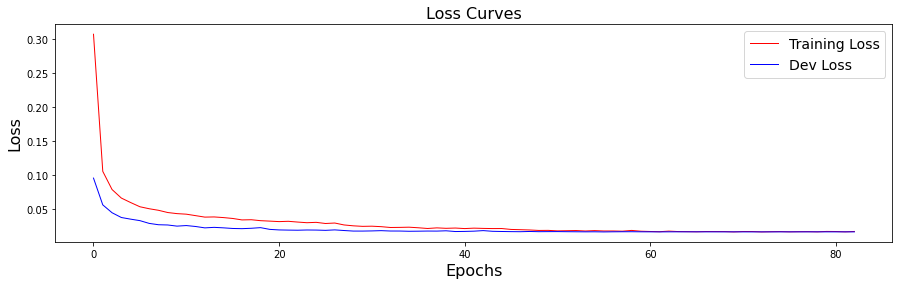

In [20]:
%matplotlib inline
plt.figure(figsize=[15, 4])
plt.plot(loss_df['TRAIN_LOSS'], 'r', linewidth=1.0)
plt.plot(loss_df['DEV_LOSS'], 'b', linewidth=1.0)
plt.legend(['Training Loss', 'Dev Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16);